# Synchonization Analysis

In [157]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')
plt.rcParams['axes.facecolor'] = '#f0f4f7'

import matplotlib.gridspec as gridspec
from matplotlib.legend import Legend
import math

import csv
import scipy.stats as st
from scipy.optimize import curve_fit
from scipy.stats import norm


import importlib
import os
import sys
import platform
import qgrid
import datetime
from scipy.interpolate import make_interp_spline, BSpline
import pickle
import random
from pathlib import Path


from numba import njit

from sync_class import SyncPhenosys
from eda_class import SpikesEDA
from behavior_class import BehaviorAnalysis
from sda_class import SpikesSDA
from report_class import SpikesReport


from synceda_phenosys import *

%load_ext autoreload
%autoreload 2

#pd.set_option('display.max_columns', 100)
#pd.set_option('display.max_rows', 100)


#plt.style.use('ggplot')
#plt.style.use('gadfly.mplstyle')

%config InlineBackend.figure_format = 'retina'
#plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')




# ================================================================================================
# specify file path & sessions

windows_folder = r"C:/Users/User/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/1 Data Analysis"
linux_folder = "/home/max/ExpanDrive/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/1 Data Analysis"
mac_folder = "/Users/max/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/1 Data Analysis"

# list -> [ session_name, [ttl_missing_rows], load_spikes, [spikes_trials_skip] ]
se_li = [('JG14_190621', [1900,1931,1996,2058,2127],True,[(0,6),(215,'end')]),
         ('JG14_190619', [111, 2781],False,[(0,1),(259,'end')]),
         ('JG14_190626', [1428, 1824, 1838, 2861, 2910, 3089, 3245, 3430, 3443],False,[(0,1),(276,'end')]),
         ('JG15_190722', [2094, 2574, 2637, 2808, 2831, 3499],False,[(271,'end')]),
         ('JG15_190725', [366,711,1487,1578,1659,2221,2666,2720,2769,2847,3371,3476],False,[(184,'end')]),
         ('JG18a_190814', [405,2621,2693,2770,2959,3015,3029,3038,3048],False,[(307,'end')]),
         ('JG18b_190828', [1744, 2363, 2648, 2701, 2731, 2778,2953,2967],True,[(0,0),(204,'end')]),
         ]



def load_session(session, missing_rows_ttl=[], lo_spikes=False, deselect_trials=[]):
    # load calss and set folder depending on platform
    if platform.system() == 'Linux':
        # Linux
        folder = linux_folder + '/' + session
    elif platform.system() == 'Windows':
        # windows
        folder = windows_folder + r"/" + session
    elif platform.system() == 'Darwin':
        folder = mac_folder + r"/" + session
        
    sync_obj = SyncPhenosys(session, folder, 7, 1, missing_rows_ttl) 
    behavior_obj = BehaviorAnalysis(sync_obj, deselect_trials)
    if lo_spikes:
        print(f"{session} -> sda")
        eda_obj = SpikesEDA(behavior_obj)
        sda_obj = SpikesSDA(eda_obj)
        report_obj = SpikesReport(sda_obj)
        session_obj = type('obj', (object,), 
                       {'sync':sync_obj,
                        'behavior':behavior_obj,
                        'eda':eda_obj,
                        'sda': sda_obj,
                        'report': report_obj,
                       })
    else:
        print(f"{session} -> behavior")
        session_obj = type('obj', (object,), 
               {'sync':sync_obj,
                'behavior':behavior_obj,
               })


    return session_obj


# ==========================================================================================
# save & load sessions from pickl functions

# save dict to pickl
def save_all_sessions_dict_pickl(all_sessions_dict):
    if platform.system() == 'Linux':
        # Linux
        folder = linux_folder
    elif platform.system() == 'Windows':
        # windows
        folder = windows_folder
    elif platform.system() == 'Darwin':
        folder = mac_folder 
    
    for key,value in all_sessions_dict.items():
        file = folder + f"/{key}.pkl"
        with open(file, 'wb') as dump:
            pickle.dump(value, dump, pickle.HIGHEST_PROTOCOL)
            

# load dict from pickl
def load_all_sessions_dict_pickl():
    if platform.system() == 'Linux':
        # Linux
        folder = linux_folder
    elif platform.system() == 'Windows':
        # windows
        folder = windows_folder
    elif platform.system() == 'Darwin':
        folder = mac_folder 
        
    file = folder + '/all_sessions_dict.pkl'
    with open(file, 'rb') as dump:
        all_sessions_dict = pickle.load(dump)
    return all_sessions_dict



# =======================================================================================
# save figures
def save_fig(name, fig):
    if platform.system() == 'Linux':
        # Linux
        folder = linux_folder+"/figures/all_figures"
    elif platform.system() == 'Windows':
        # windows
        folder = windows_folder+"\figures\all_figures"
    elif platform.system() == 'Darwin':
        folder = mac_folder+"/figures/all_figures"
    try:
        fig.savefig(folder+"/"+name+'.png',dpi=200, format='png', bbox_inches='tight')
    except:
        if platform.system() == 'Linux':
            # Linux
            folder = linux_folder+"/figures"
        elif platform.system() == 'Windows':
            # windows
            folder = windows_folder+"\figures"
        elif platform.system() == 'Darwin':
            folder = mac_folder+"/figures"
        fig.savefig(folder+"/"+name+'.png',dpi=200, format='png', bbox_inches='tight')


def savefig(name,fig):
    if platform.system() == 'Linux':
        # Linux
        folder = linux_folder + '/figures' 
    elif platform.system() == 'Windows':
        # windows
        folder = windows_folder + r"/figures" 
    elif platform.system() == 'Darwin':
        folder = mac_folder + r"/figures" 

    Path(folder).mkdir(parents=True, exist_ok=True)

    fig.savefig(folder+"/"+name+'.png',dpi=200, format='png', bbox_inches='tight')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load alls session

all_sessions_dict = dict()
# load all sessions into dict
for session_name,missing_rows_ttl,load_spikes,spikes_trials_skip in se_li:
    all_sessions_dict[session_name]=load_session(session_name, missing_rows_ttl, load_spikes, spikes_trials_skip)

all_sessions_dict['JG15_190722'].sync.combined_df.loc[(131,32,428,6),"Delta (TTL-CSV)"]=30

JG14_190621 -> sda
JG14_190619 -> behavior
JG14_190626 -> behavior
JG15_190722 -> behavior
JG15_190725 -> behavior
JG18a_190814 -> behavior
JG18b_190828 -> sda


In [9]:
all_sessions_trial_info_df = list()
for key,se in all_sessions_dict.items():
    length_df = get_trial_length_dif(se)
    all_sessions_trial_info_df.append(length_df)

## TTL Time Diff

<IPython.core.display.Javascript object>


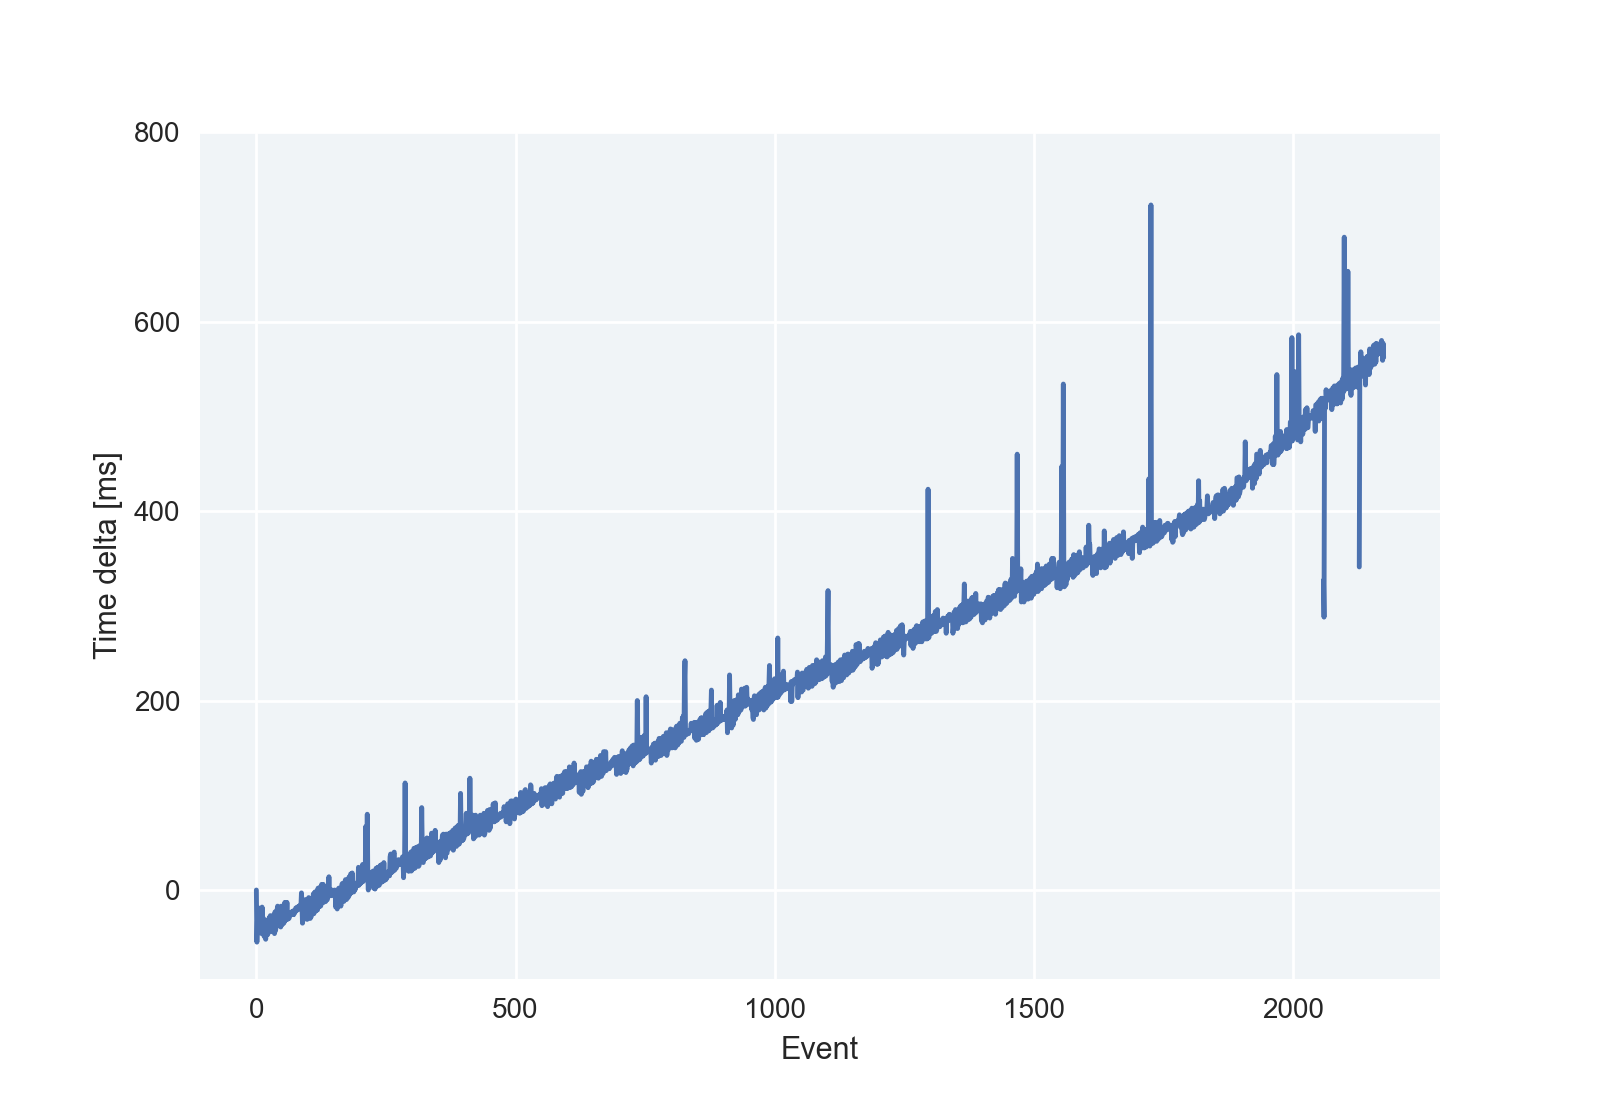

<IPython.core.display.Javascript object>


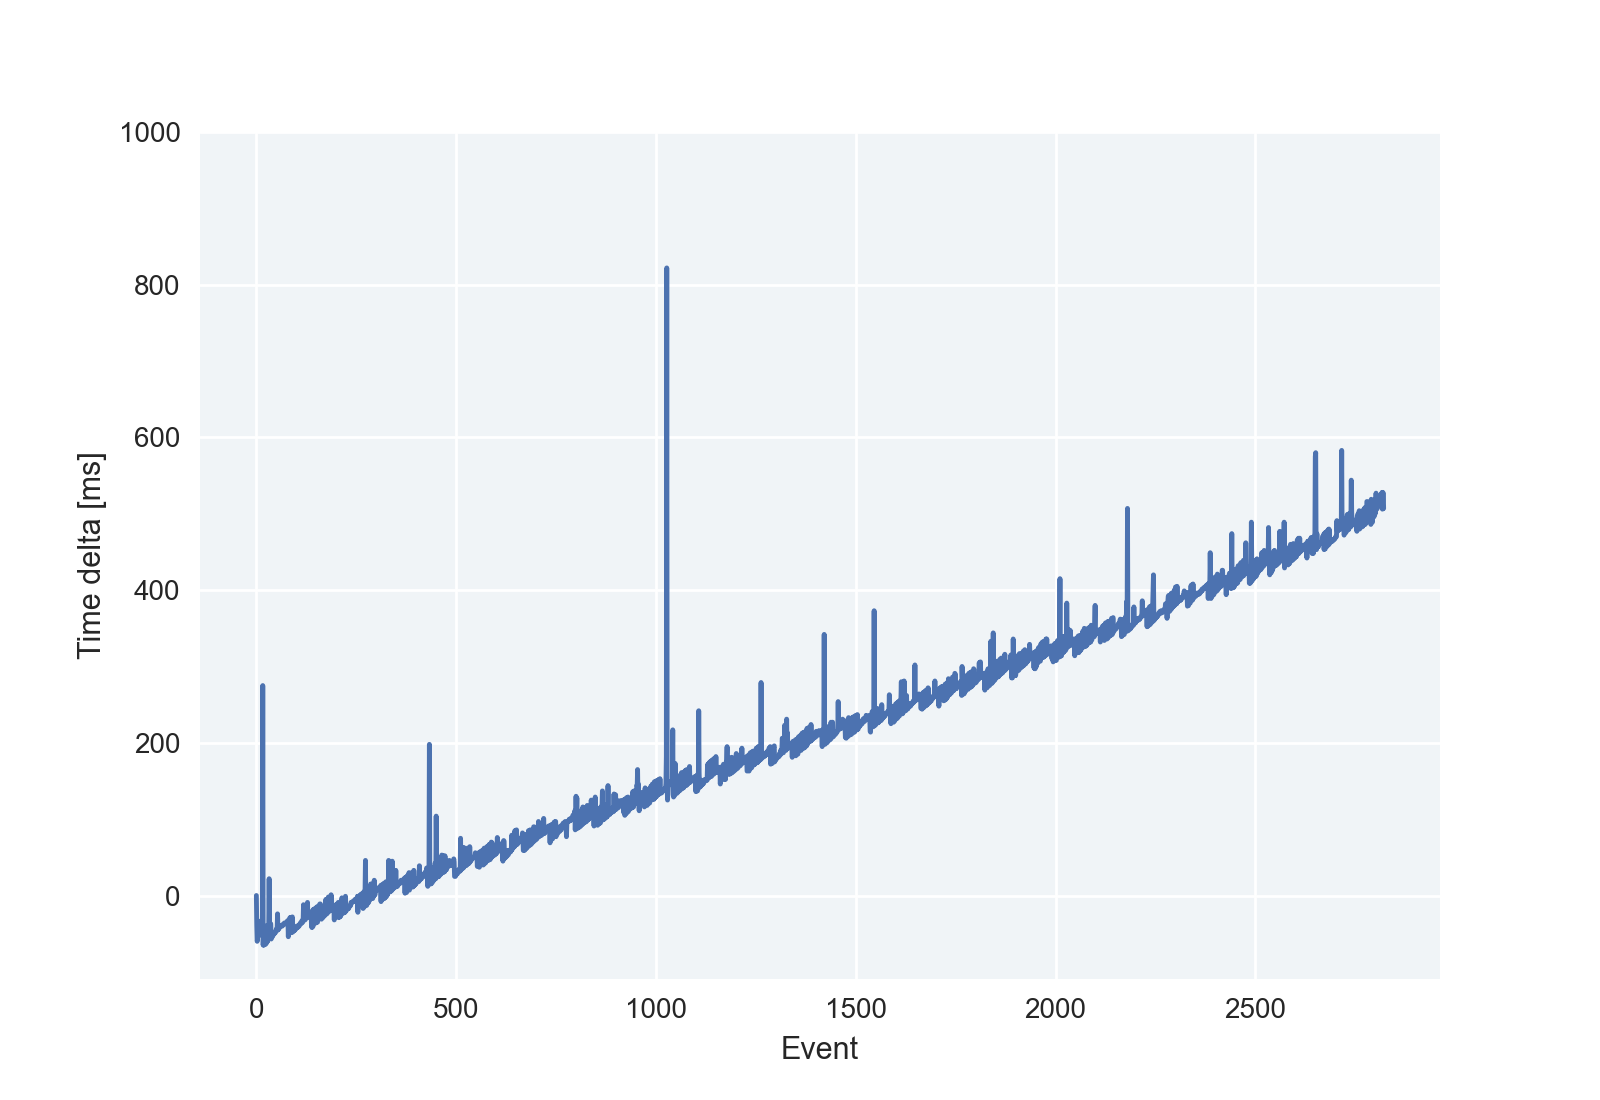

<IPython.core.display.Javascript object>


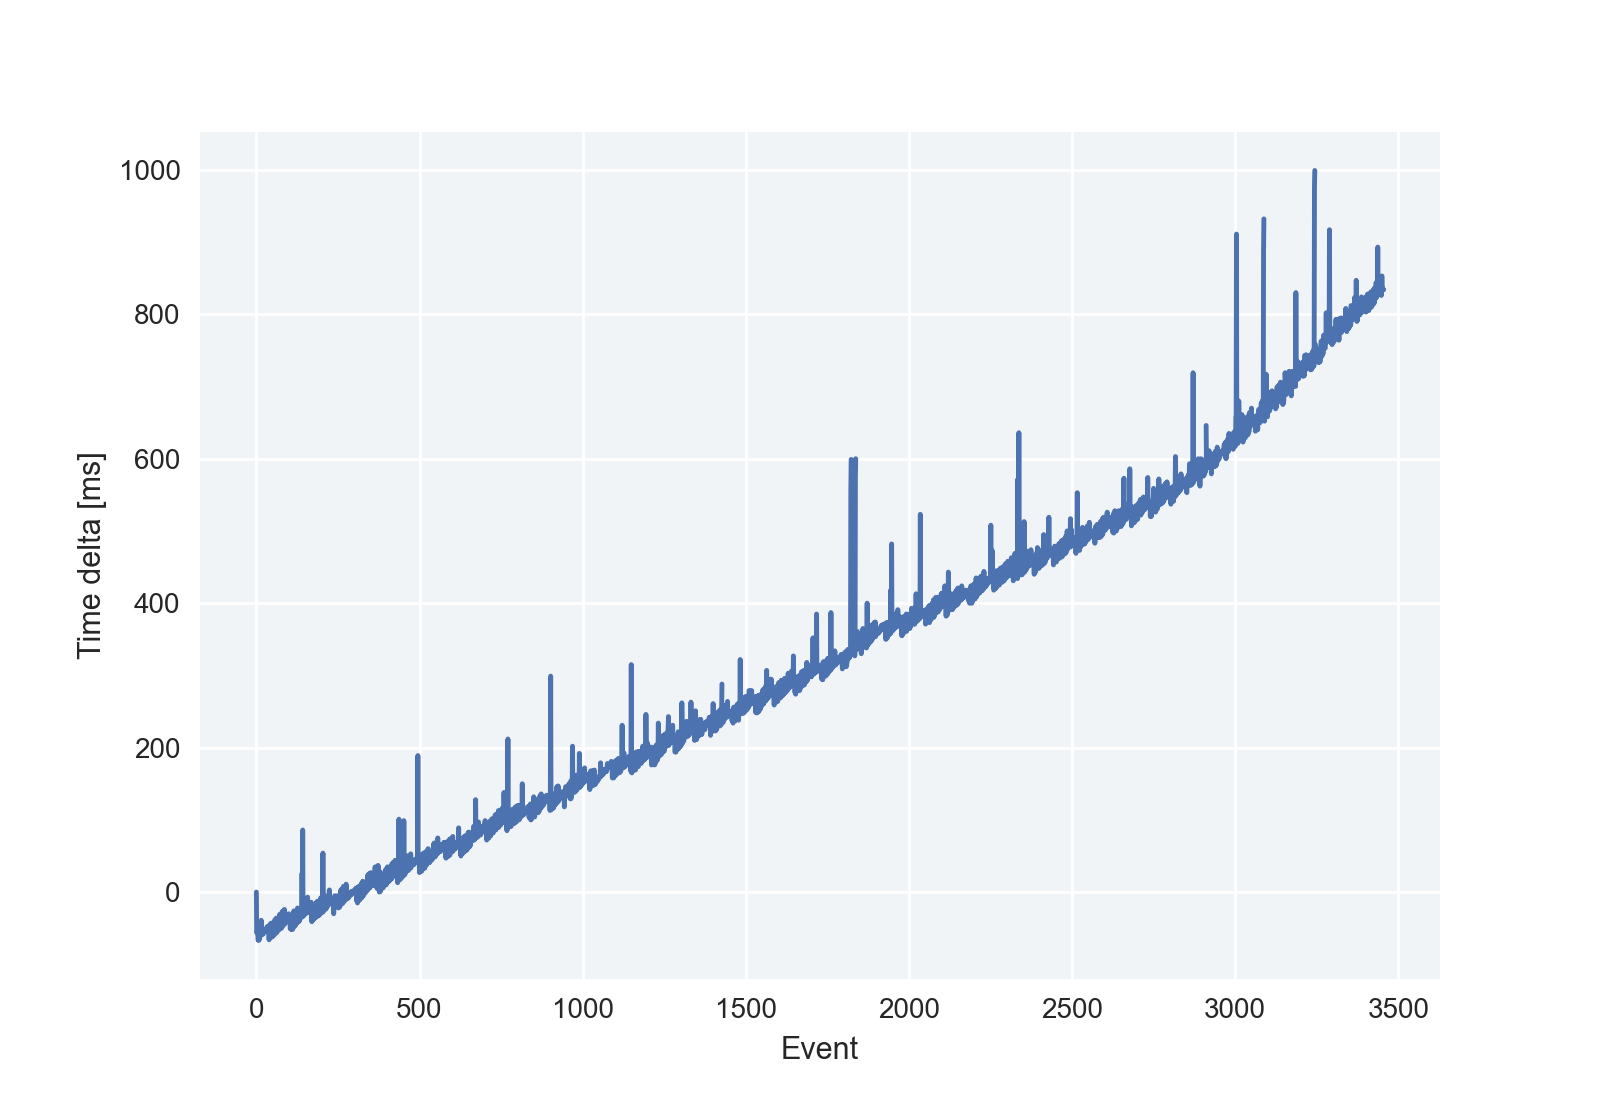

<IPython.core.display.Javascript object>


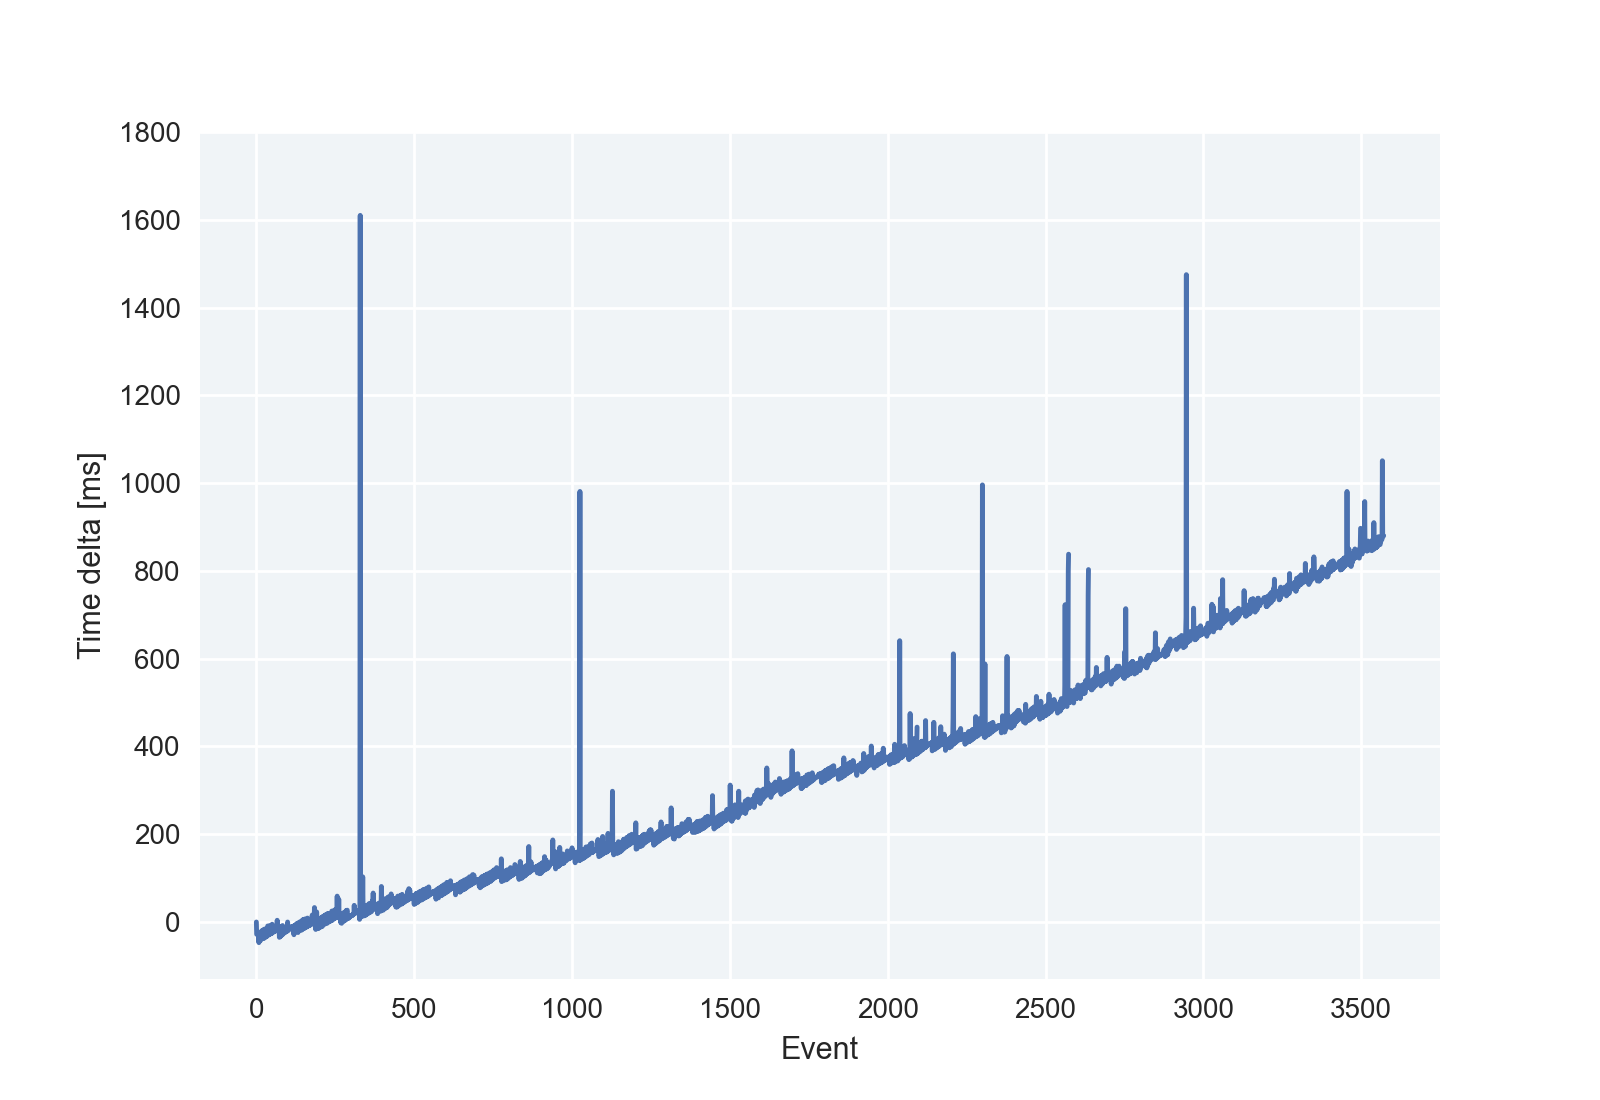

<IPython.core.display.Javascript object>


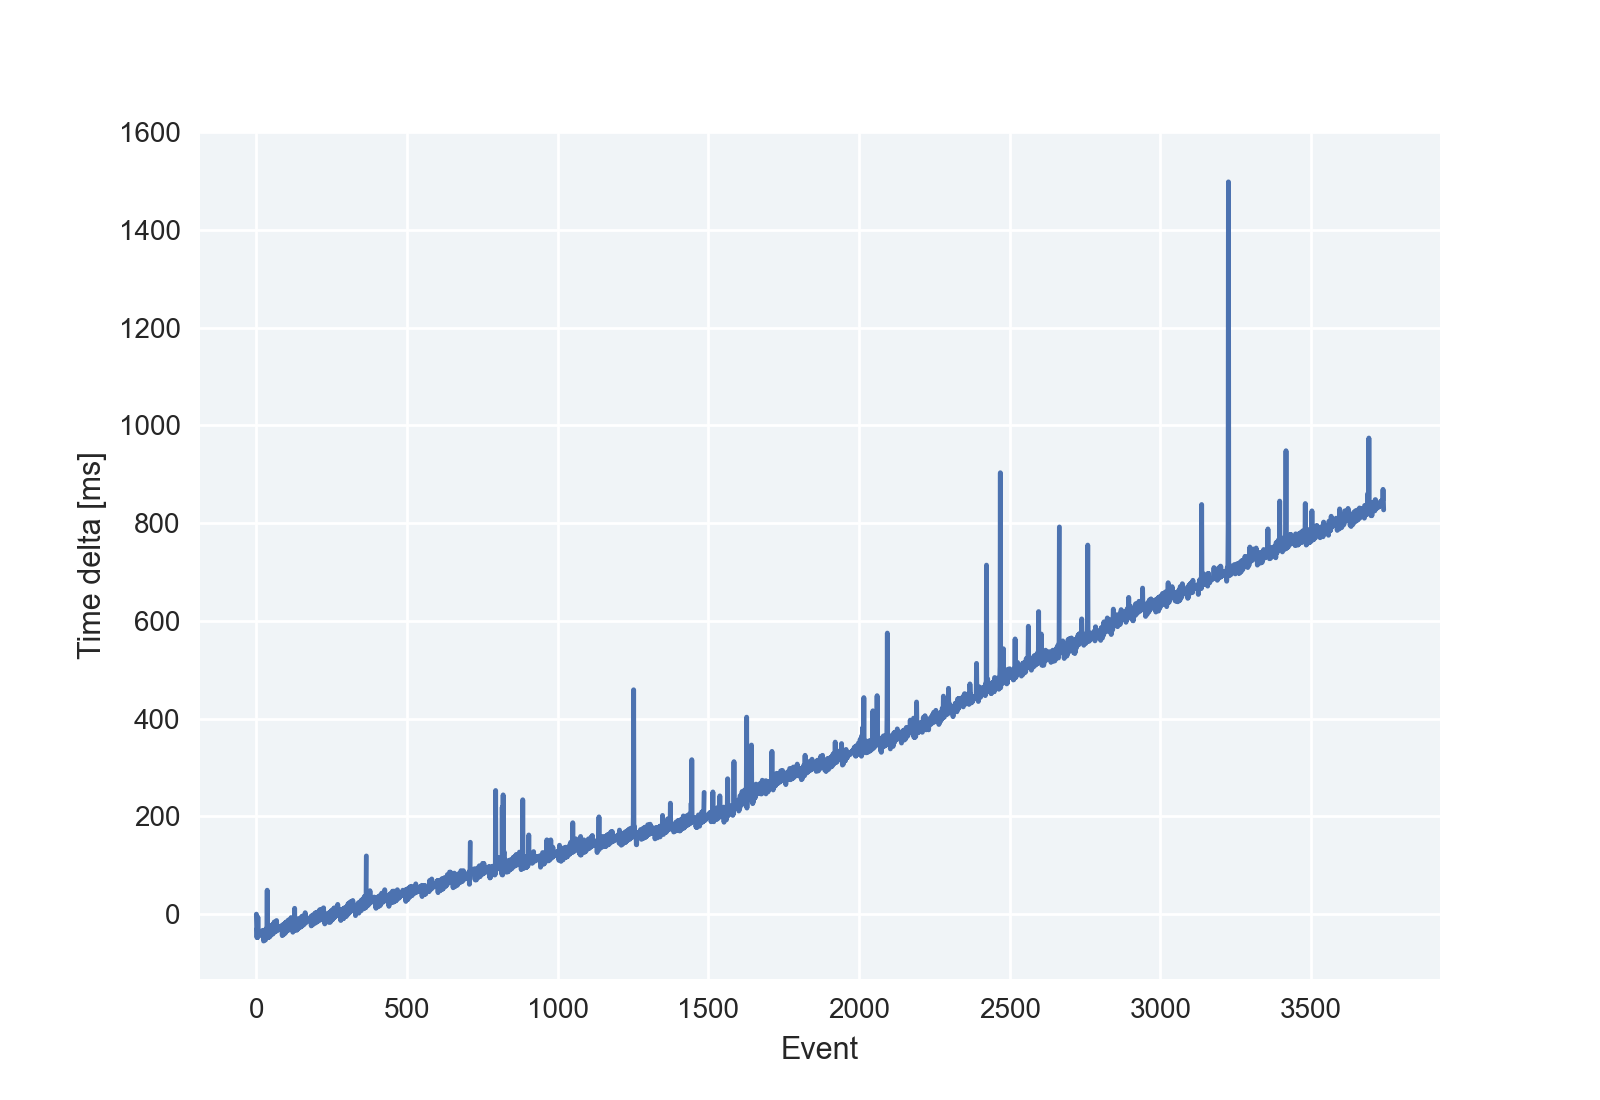

<IPython.core.display.Javascript object>


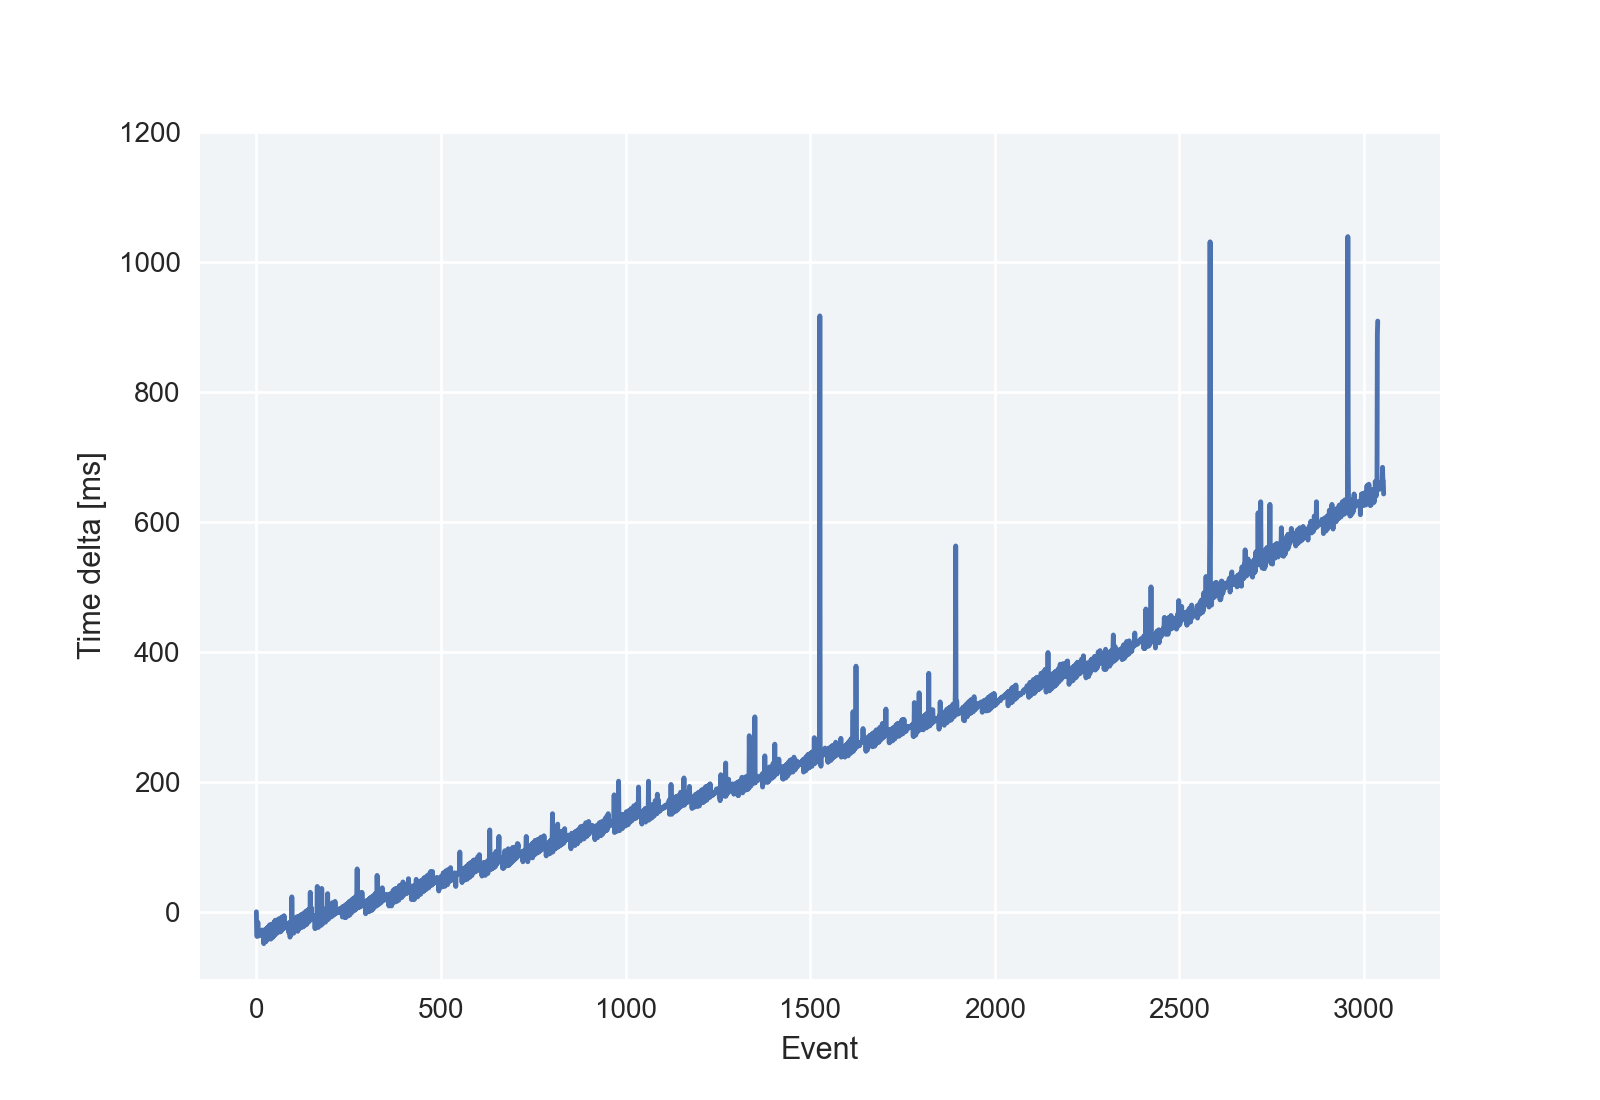

<IPython.core.display.Javascript object>


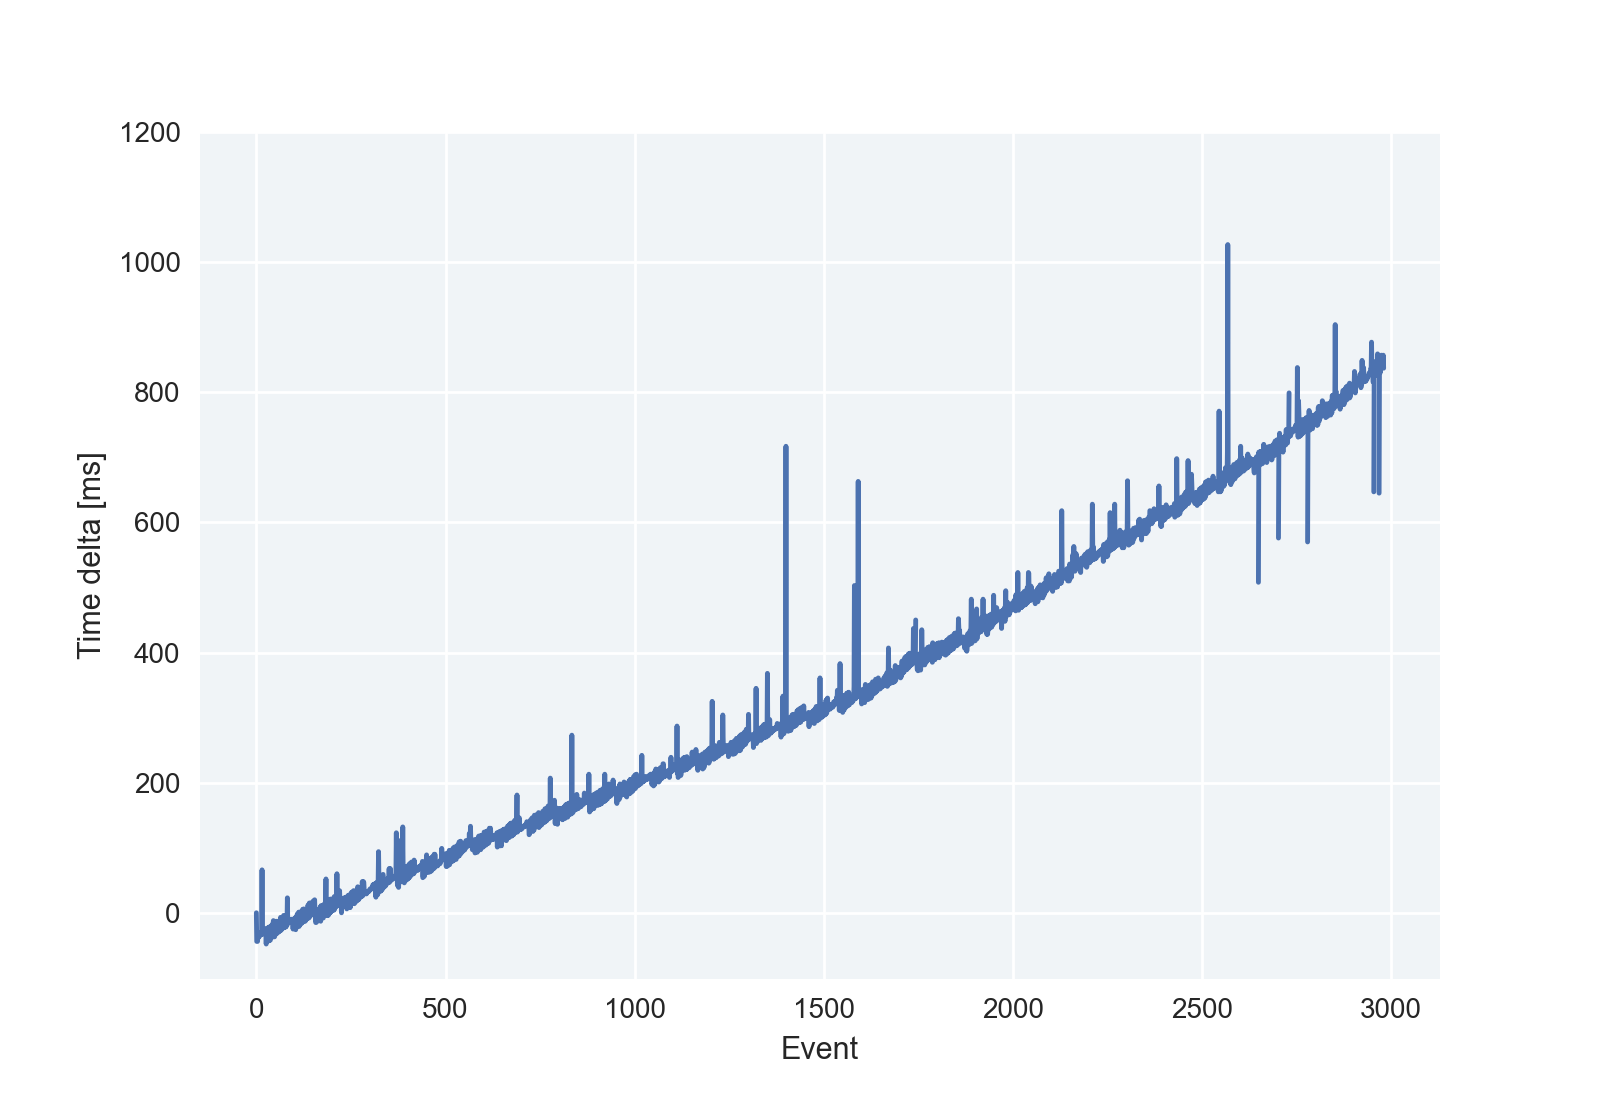

In [159]:
for key,se in all_sessions_dict.items():
    fig,ax = plt_dif(se)
    se.sync.save_fig(f"sync_ttl_dif",fig)


<IPython.core.display.Javascript object>


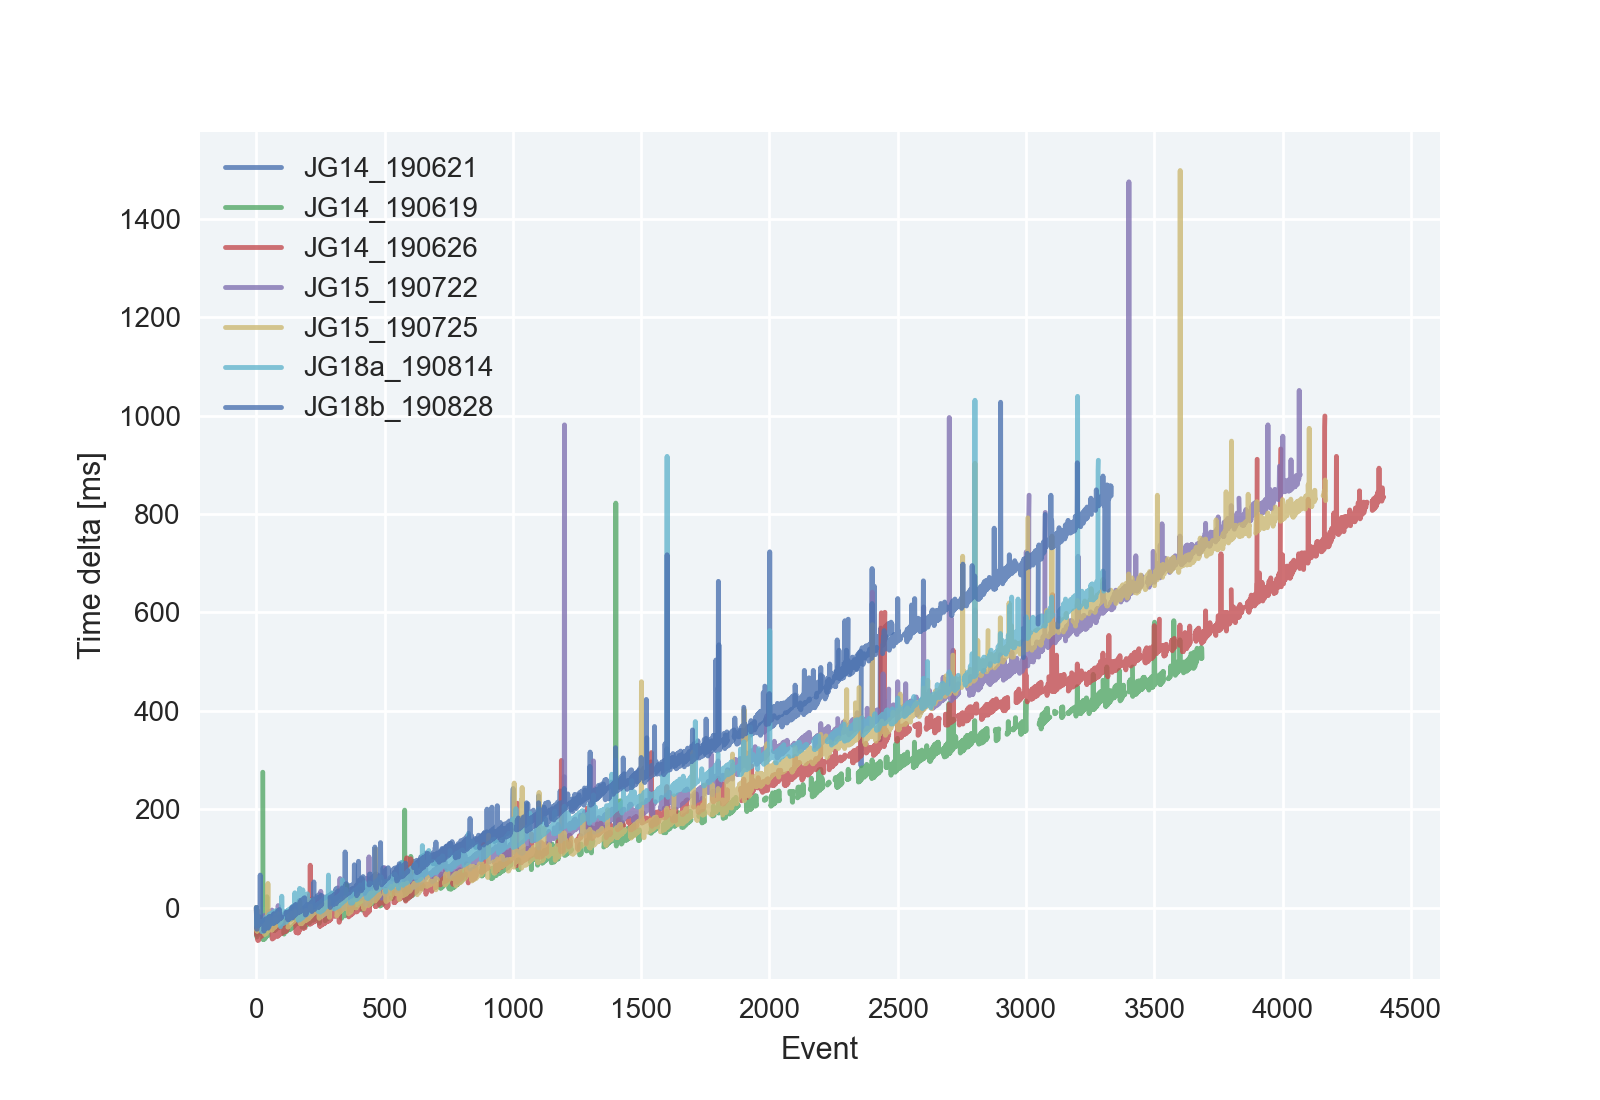

In [158]:
fig,ax = plt.subplots()
max_x = 0

for key,se in all_sessions_dict.items():
    se.sync.combined_df['Delta (TTL-CSV)'].plot(label=se.sync.session, alpha=0.8,ax=ax)
    se_max_x = se.sync.combined_df.shape[0]
    if se_max_x > max_x:
        max_x = se_max_x

ax.set_xlabel("Event")
ax.set_ylabel("Time delta [ms]")
ax.legend()

start = 0
stop = se_max_x
range_x = np.arange(0, stop+1500, 500).astype(int)
ax.set_xticks(range_x)
labels_x = range_x.astype(str).tolist()
ax.set_xticklabels(labels_x)

savefig("ttl_delta", fig)


<IPython.core.display.Javascript object>


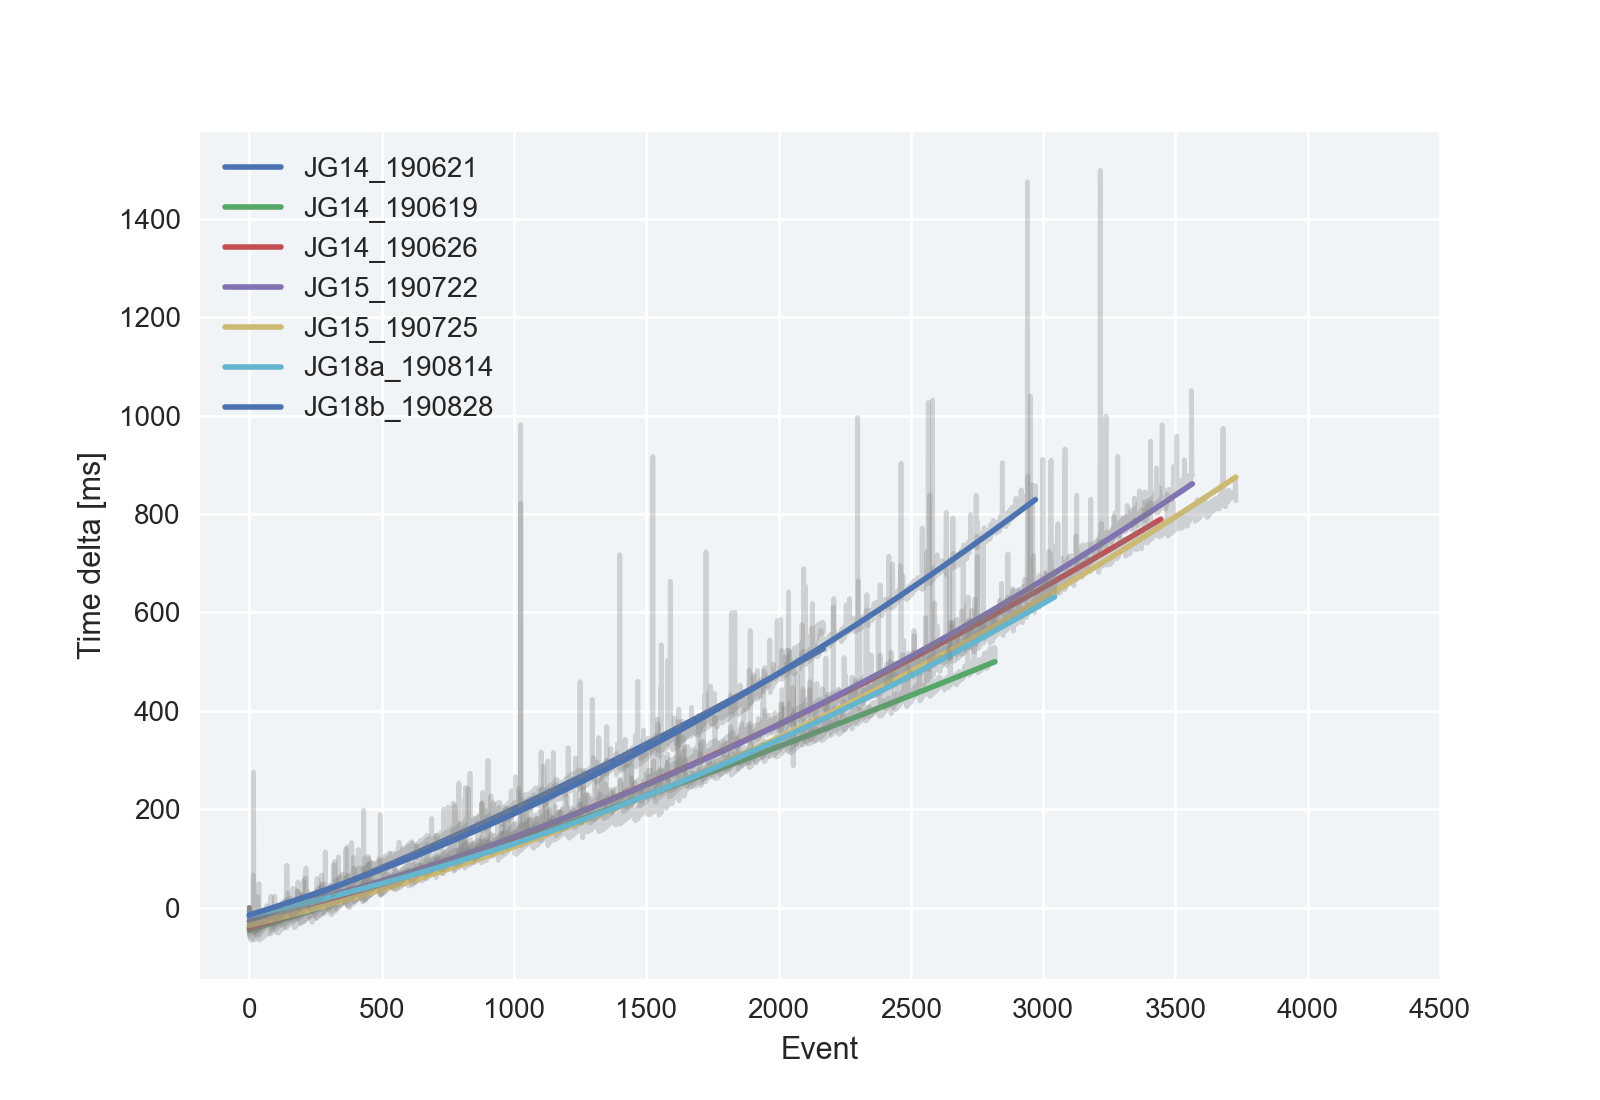

y = 0.20581 * x + 0.00002 * x^2 + -27.62327
y = 0.16904 * x + 0.00001 * x^2 + -46.18029
y = 0.15881 * x + 0.00002 * x^2 + -41.63060
y = 0.12846 * x + 0.00003 * x^2 + -18.38659
y = 0.12831 * x + 0.00003 * x^2 + -35.83041
y = 0.11275 * x + 0.00003 * x^2 + -15.81575
y = 0.16590 * x + 0.00004 * x^2 + -15.16294
Session: JG14_190621, drift: 553.5871345741832
Session: JG14_190619, drift: 545.8320307412174
Session: JG14_190626, drift: 831.0690410717814
Session: JG15_190722, drift: 879.6706382714875
Session: JG15_190725, drift: 910.5261979422587
Session: JG18a_190814, drift: 646.9913158310494
Session: JG18b_190828, drift: 844.3379259924077


In [171]:
fig,ax = plt.subplots()
max_x = 0
fit_curves_pol = list()

for key,se in all_sessions_dict.items():
    x,y,x_line,y_line = fit_curve(se,'pol')
    label=se.sync.session
    plt_fit_curve(ax,x,y,x_line,y_line,label)
    fit_curves_pol.append([label,x,y,x_line,y_line])
    
ax.set_xlabel("Event")
ax.set_ylabel("Time delta [ms]")
ax.legend(loc=2)

start = 0
stop = se_max_x
range_x = np.arange(0, stop+1500, 500).astype(int)
ax.set_xticks(range_x)
labels_x = range_x.astype(str).tolist()
ax.set_xticklabels(labels_x)

savefig("ttl_delta_fitted_pol", fig)


for cuve in fit_curves_pol:
    print(f"Session: {cuve[0]}, drift: {cuve[4][-1]-cuve[4][0]}")

<IPython.core.display.Javascript object>


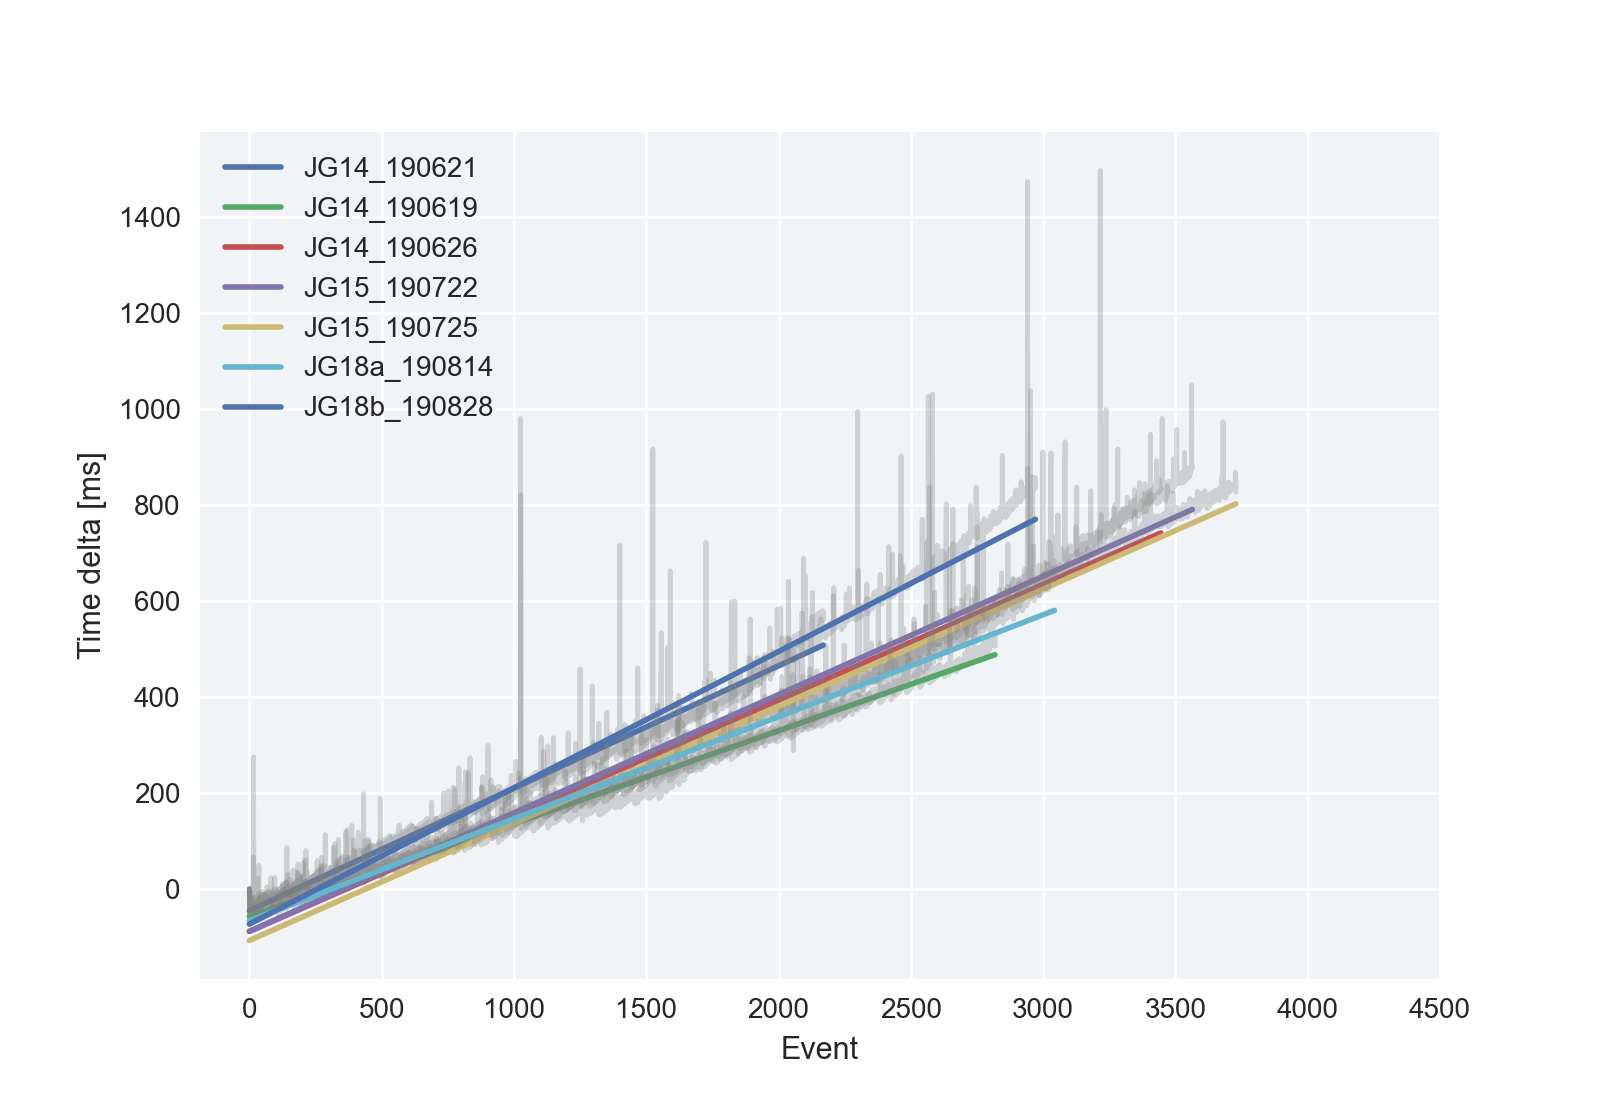

y = 0.25525 * x + -45.49588
y = 0.19370 * x + -57.76172
y = 0.24126 * x + -88.97284
y = 0.24685 * x + -88.71367
y = 0.24427 * x + -107.88234
y = 0.21265 * x + -66.48180
y = 0.28423 * x + -73.75805


In [170]:
fig,ax = plt.subplots()
max_x = 0
fit_curves_lin = list()

for key,se in all_sessions_dict.items():
    x,y,x_line,y_line = fit_curve(se,'lin')
    label=se.sync.session
    plt_fit_curve(ax,x,y,x_line,y_line,label)
    fit_curves_lin.append([label,x,y,x_line,y_line])
    
ax.set_xlabel("Event")
ax.set_ylabel("Time delta [ms]")
ax.legend(loc=2)

start = 0
stop = se_max_x
range_x = np.arange(0, stop+1500, 500).astype(int)
ax.set_xticks(range_x)
labels_x = range_x.astype(str).tolist()
ax.set_xticklabels(labels_x)

savefig("ttl_delta_fitted_lin", fig)

## Trial Length Diff

<IPython.core.display.Javascript object>


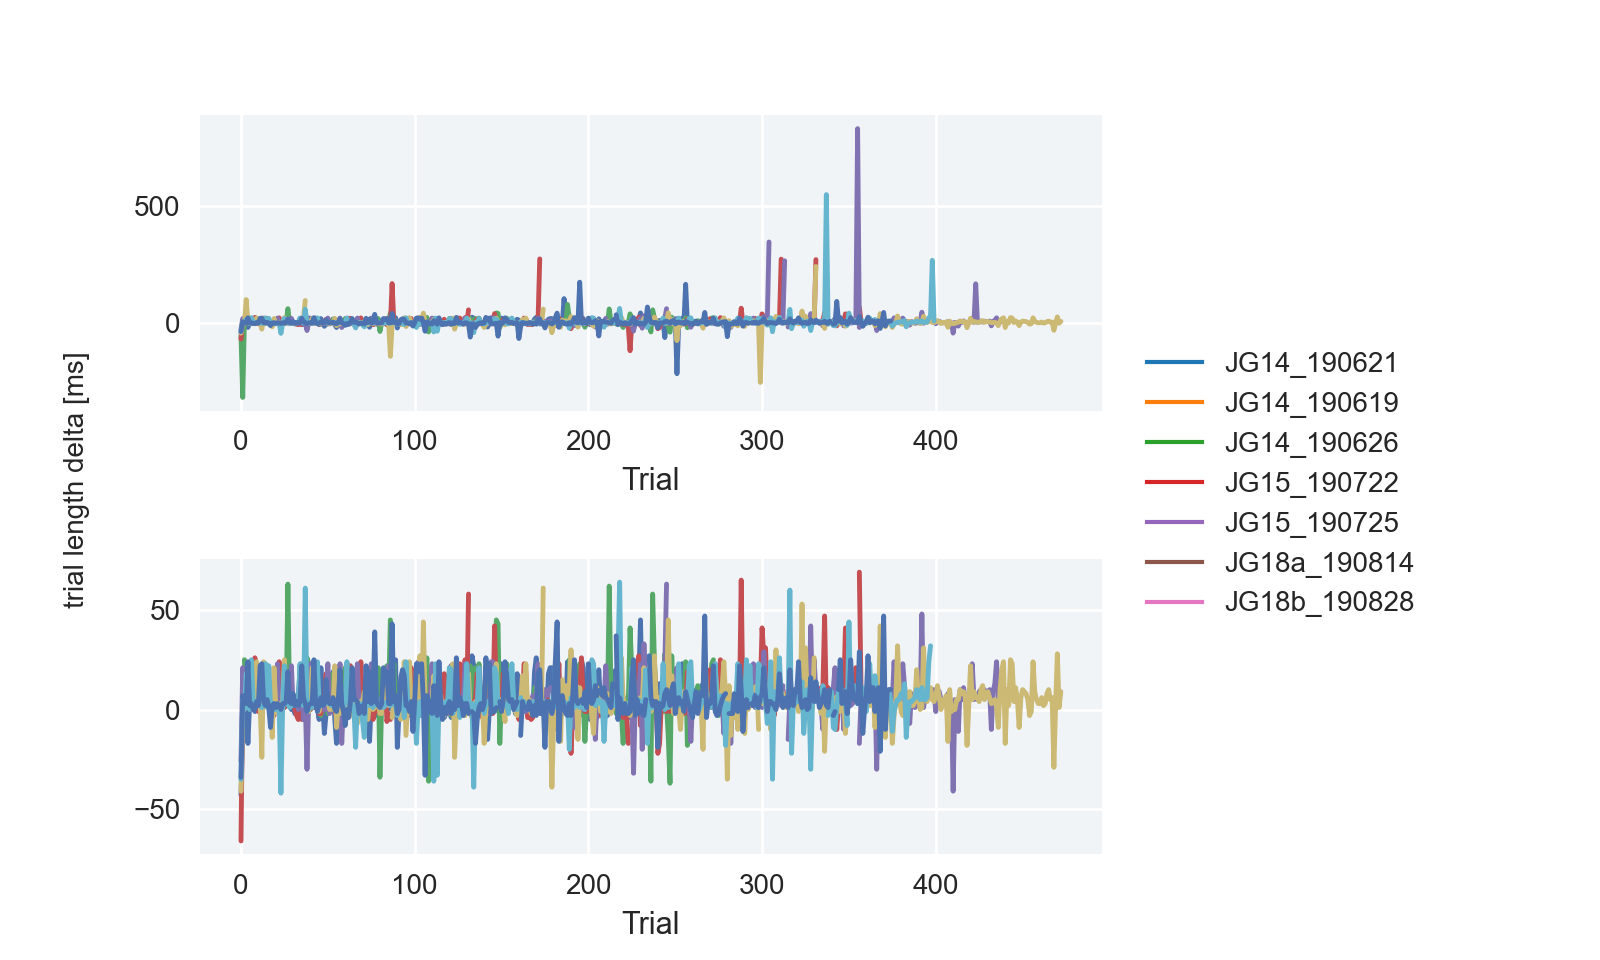

In [163]:
labels = []

width = 8
fig = plt.figure(constrained_layout=True,figsize=(width, width * (3 / 5)))
gs = gridspec.GridSpec(ncols=2,
                        nrows=2,
                        width_ratios=[4, 1],
                        #height_ratios=[2, 1],
                        hspace=0.5,  # ,wspace=0.2
                        )
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[:,1])

for key,se in all_sessions_dict.items():
    length_df = get_trial_length_dif(se)
    ax1.plot(length_df["trial length dif [TTL - CSV]"],label=key)
    lines+= ax2.plot(length_df["trial length cor"],label=key)
    labels.append(key)
    

for ax in [ax1,ax2]:
    ax.set_xlabel("Trial")
    #ax.set_ylabel("trial length dif (TTL - CSV) [ms]")
    #ax.legend()

# create legend in axis 3
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax3.xaxis.get_label(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax3.yaxis.get_label(), visible=False)
# hide frame
ax3.axis('off')

# create legend
pos1 = ax3.get_position() # get the original position 
pos2 = [pos1.x0, pos1.y0, pos1.width, pos1.height] 
ax3.set_position(pos2)
#labels = lines.get_label()
#ax3.legend(label, loc=0)
leg = Legend(ax3, lines, labels,loc='center right')
ax3.add_artist(leg);

# set y label
fig.text(0.04, 0.5, "trial length delta [ms]", va='center', rotation='vertical')

savefig("trial_length_norm", fig)

<IPython.core.display.Javascript object>


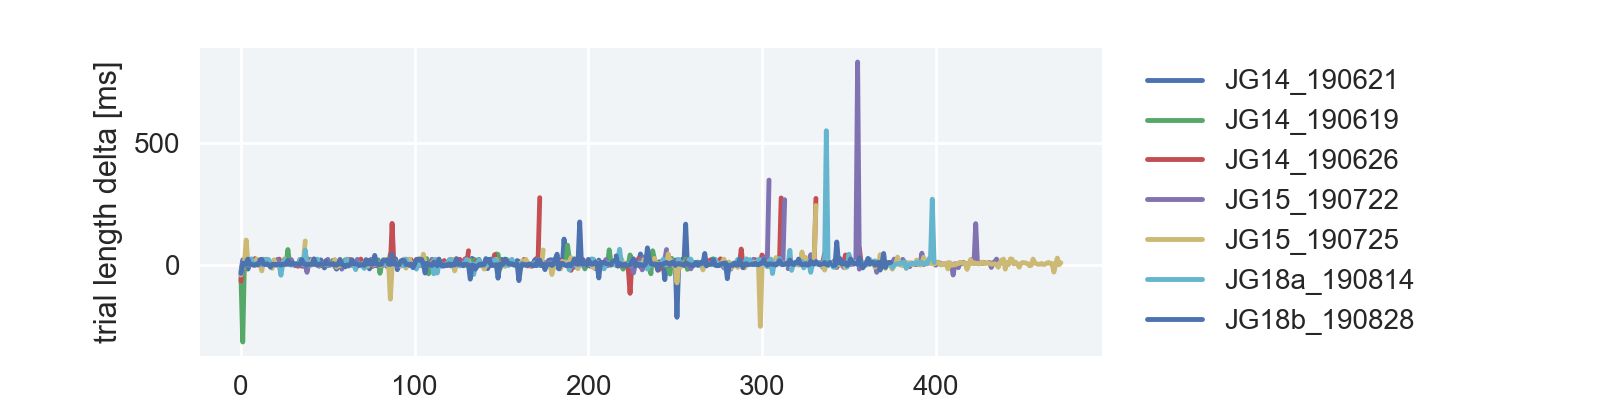

In [164]:
labels = []
lines=[]

width = 8
fig = plt.figure(constrained_layout=True,figsize=(width, width * (1 / 4)))
gs = gridspec.GridSpec(ncols=2,
                        nrows=1,
                        width_ratios=[4, 1],
                        hspace=0.5,  # ,wspace=0.2
                        )
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

for key,se in all_sessions_dict.items():
    length_df = get_trial_length_dif(se)
    lines+=ax1.plot(length_df["trial length dif [TTL - CSV]"],label=key)
    #lines+= ax1.plot(length_df["trial length cor"],label=key)
    labels.append(key)
    
for ax in [ax1,ax2]:
    ax.set_xlabel("Trial")
    ax.set_ylabel("trial length delta [ms]")

# create legend in axis 3
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax2.xaxis.get_label(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.yaxis.get_label(), visible=False)
# hide frame
ax2.axis('off')

# create legend
pos1 = ax2.get_position() # get the original position 
pos2 = [pos1.x0, pos1.y0, pos1.width, pos1.height] 
ax2.set_position(pos2)
leg = Legend(ax2, lines, labels,loc='center right')
ax2.add_artist(leg)


savefig("trial_length_all", fig)

<IPython.core.display.Javascript object>


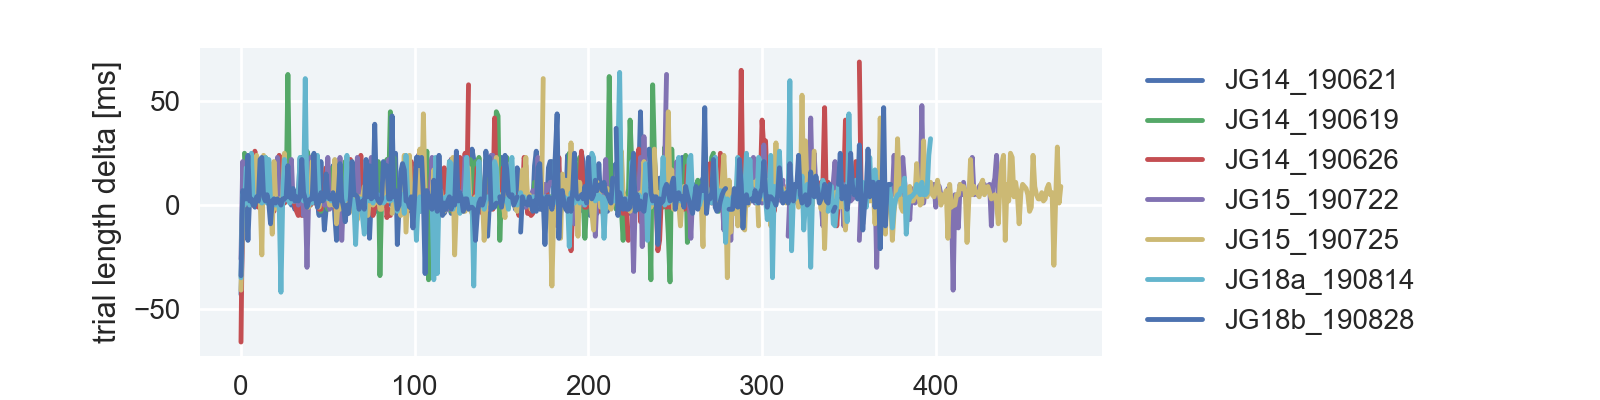

In [166]:
labels = []
lines=[]


width = 8
fig = plt.figure(constrained_layout=True,figsize=(width, width * (1 / 4)))
gs = gridspec.GridSpec(ncols=2,
                        nrows=1,
                        width_ratios=[4, 1],
                        hspace=0.5,  # ,wspace=0.2
                        )
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

for key,se in all_sessions_dict.items():
    length_df = get_trial_length_dif(se)
    lines+= ax1.plot(length_df["trial length cor"],label=key)
    labels.append(key)
    
for ax in [ax1,ax2]:
    ax.set_xlabel("Trial")
    ax.set_ylabel("trial length delta [ms]")

# create legend in axis 3
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax2.xaxis.get_label(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.yaxis.get_label(), visible=False)
# hide frame
ax2.axis('off')

# create legend
pos1 = ax2.get_position() # get the original position 
pos2 = [pos1.x0, pos1.y0, pos1.width, pos1.height] 
ax2.set_position(pos2)
leg = Legend(ax2, lines, labels,loc='center right')
ax2.add_artist(leg);


savefig("trial_length_nooutlier", fig)

## Test for nomral distribution

<IPython.core.display.Javascript object>


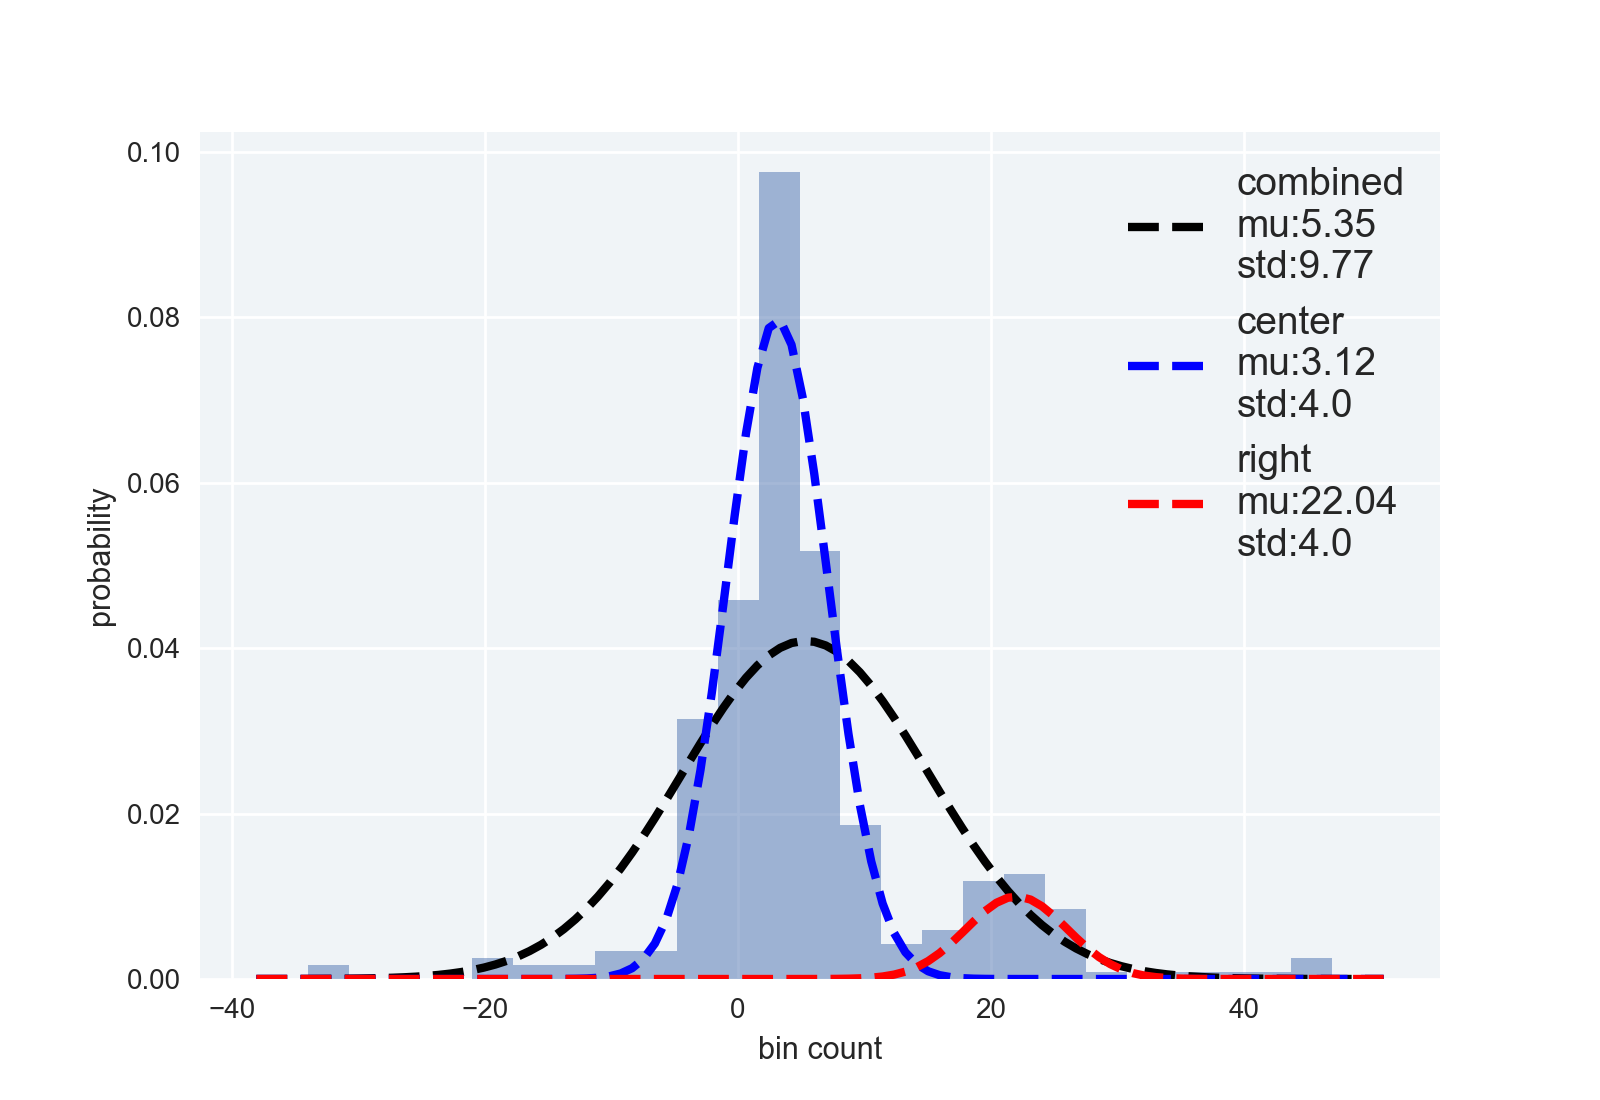

In [169]:
fig,ax = plt_fit_normdist(length_df["trial length cor"].dropna())
savefig("trial_length_norm", fig)

<IPython.core.display.Javascript object>


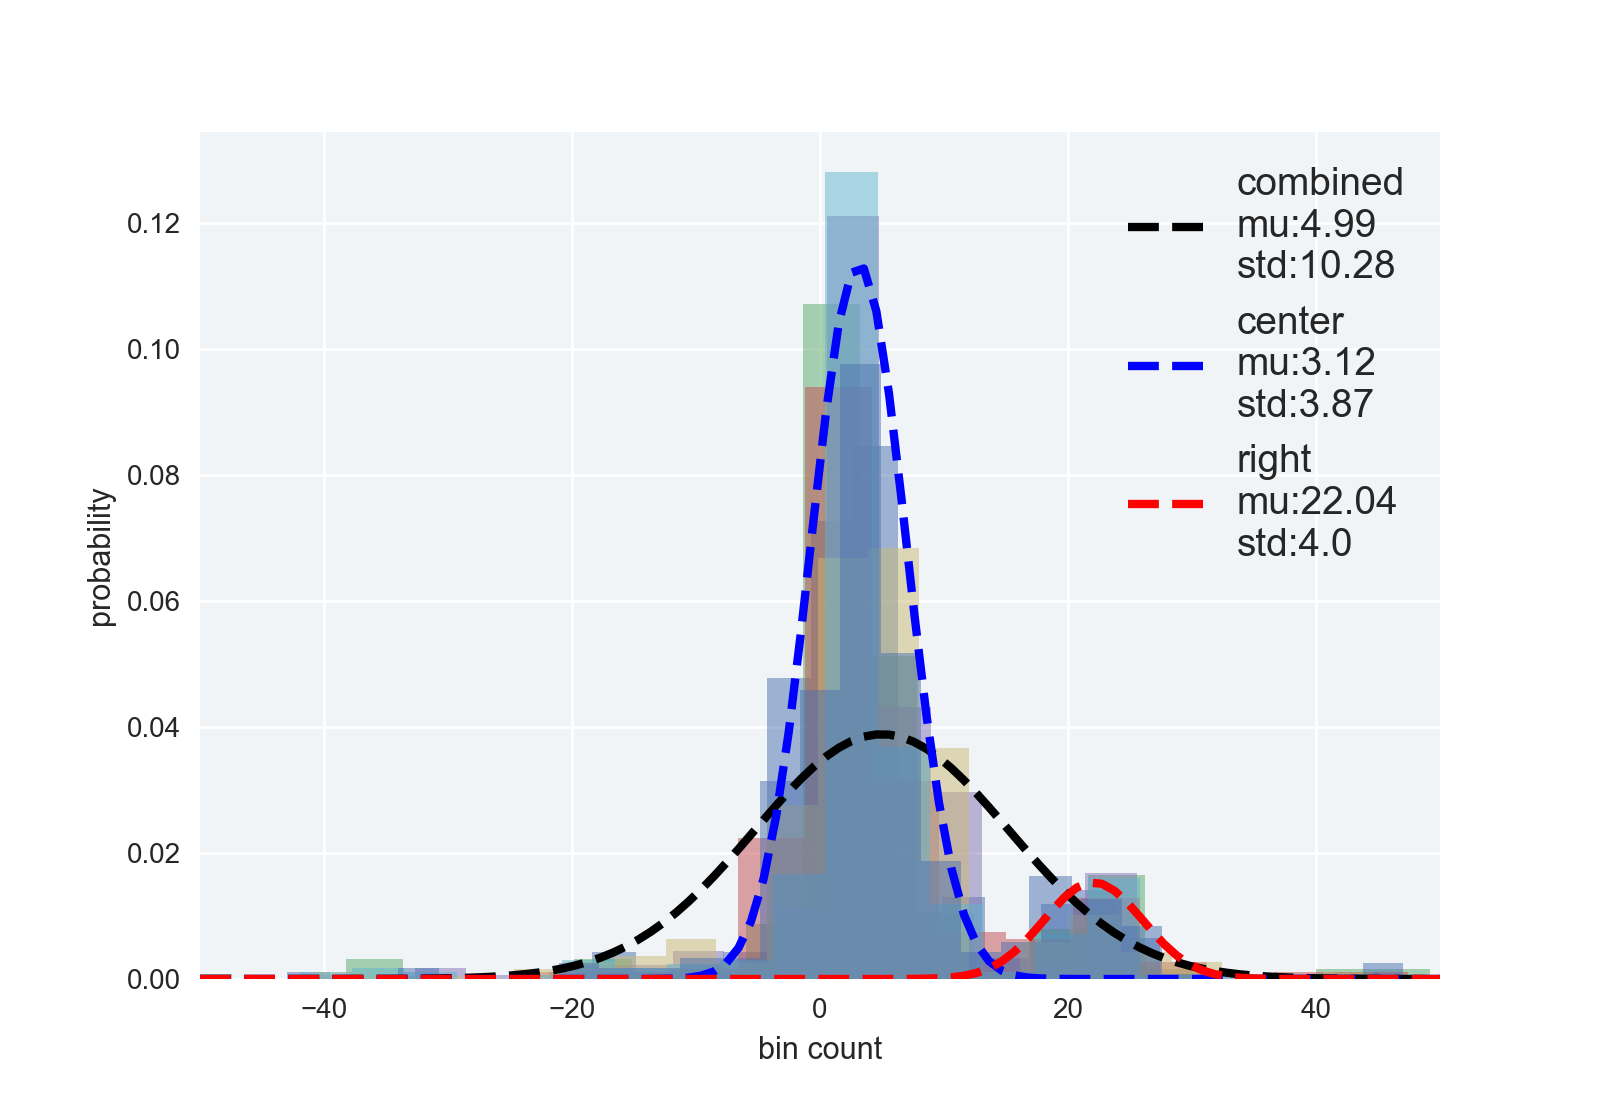

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [168]:
all_list = list()


fig,ax = plt.subplots()

for length_df in all_sessions_trial_info_df:
    ax = plt_fit_normdist(length_df["trial length cor"].dropna(),ax,norm_fit=False)
    all_list.extend(length_df["trial length cor"].dropna().values)

legend = ax.get_legend()
legend.remove()

ax.set_xlim([-50, 50])

# plot combined fit
mu, std = norm.fit(all_list)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, "k", linestyle='--', linewidth=3,label=f"combined\nmu:{round_up(mu,2)}\nstd:{round_up(std,2)}")

# center
mu=3.12
std=3.87
#x = np.linspace(-25, 29, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p*1.1, "blue", linestyle='--', linewidth=3,label=f"center\nmu:{round_up(mu,2)}\nstd:{round_up(std,2)}")

# right
mu=22.04
std=4
p = norm.pdf(x, mu, std)
#x = np.linspace(12, 33, 100)
ax.plot(x, p/6.5, "red", linestyle='--', linewidth=3,label=f"right\nmu:{round_up(mu,2)}\nstd:{round_up(std,2)}")

ax.legend(prop={'size': 14})

savefig("trial_length_norm_all", fig)

In [18]:
for length_df in all_sessions_trial_info_df:
    test_sapiro(length_df["trial length cor"].dropna())

Statistics=0.862, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.719, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.753, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.776, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.868, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.747, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.860, p=0.000
Sample does not look Gaussian (reject H0)


In [134]:
se.sync.combined_df

TTL Start  TTL Length   TTL Event  \
All Trial Trial index Group Index                                       
0.0       0.0   0     0              334072.0        15.0       start   
                1     1              354448.0        39.0         cue   
                2     2              355107.0        61.0       sound   
                3     3              355807.0        80.0    openloop   
                4     4              461734.0       120.0  right_norw   
...                                       ...         ...         ...   
726.0     374.0 3328  6            32277847.0       220.0         end   
NaN       NaN   3329  0            32278111.0        18.0       start   
                3330  1            32298152.0        36.0         cue   
                3331  2            32298808.0        60.0       sound   
                3332  3            32299488.0        81.0    openloop   

                                   TTL Start norm  TTL index   CSV Start  \
All Trial Trial index Group Index                                          
0.0       0.0   0     0                       0.0        0.0     14600.0   
                1     1                   20376.0        1.0     35020.0   
                2     2                   21035.0        2.0     35679.0   
                3     3                   21735.0        3.0     36379.0   
                4     4                  127662.0        4.0    142299.0   
...                                           ...        ...         ...   
726.0     374.0 3328  6                31943775.0     2976.0  31957520.0   
NaN       NaN   3329  0                31944039.0     2977.0  31957799.0   
                3330  1                31964080.0     2978.0  31977839.0   
                3331  2                31964736.0     2979.0  31978479.0   
                3332  3                31965416.0     2980.0  31979179.0   

                                    CSV Event CSV Probability  CSV Start norm  \
All Trial Trial index Group Index                                               
0.0       0.0   0     0                 start           0.750             0.0   
                1     1                   cue           0.750         20420.0   
                2     2                 sound           0.750         21079.0   
                3     3              openloop           0.750         21779.0   
                4     4            right_norw           0.750        127699.0   
...                                       ...             ...             ...   
726.0     374.0 3328  6                   end           0.125      31942920.0   
NaN       NaN   3329  0                 start           0.125      31943199.0   
                3330  1                   cue           0.125      31963239.0   
                3331  2                 sound           0.125      31963879.0   
                3332  3              openloop           0.125      31964579.0   

                                   CSV index  Delta (TTL-CSV) Compare  \
All Trial Trial index Group Index                                       
0.0       0.0   0     0                  0.0              0.0    True   
                1     1                  1.0            -44.0    True   
                2     2                  2.0            -44.0    True   
                3     3                  3.0            -44.0    True   
                4     4                  4.0            -37.0    True   
...                                      ...              ...     ...   
726.0     374.0 3328  6               2976.0            855.0    True   
NaN       NaN   3329  0               2977.0            840.0    True   
                3330  1               2978.0            841.0    True   
                3331  2               2979.0            857.0    True   
                3332  3               2980.0            837.0    True   

                                  Good Trial  
All Trial Trial index Group Index             

In [151]:
info_df = se.sync.combined_df.copy()
info_df = info_df.droplevel([0,2,3])
mini = length_df.loc[np.logical_and(length_df["trial length cor"]>14,length_df["trial length cor"]<33)]
not_mini = length_df.loc[np.invert(np.logical_and(length_df["trial length cor"]>14,length_df["trial length cor"]<33))]

qgrid.show_grid(info_df.loc[mini.index])

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [146]:
qgrid.show_grid(mini)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

<IPython.core.display.Javascript object>


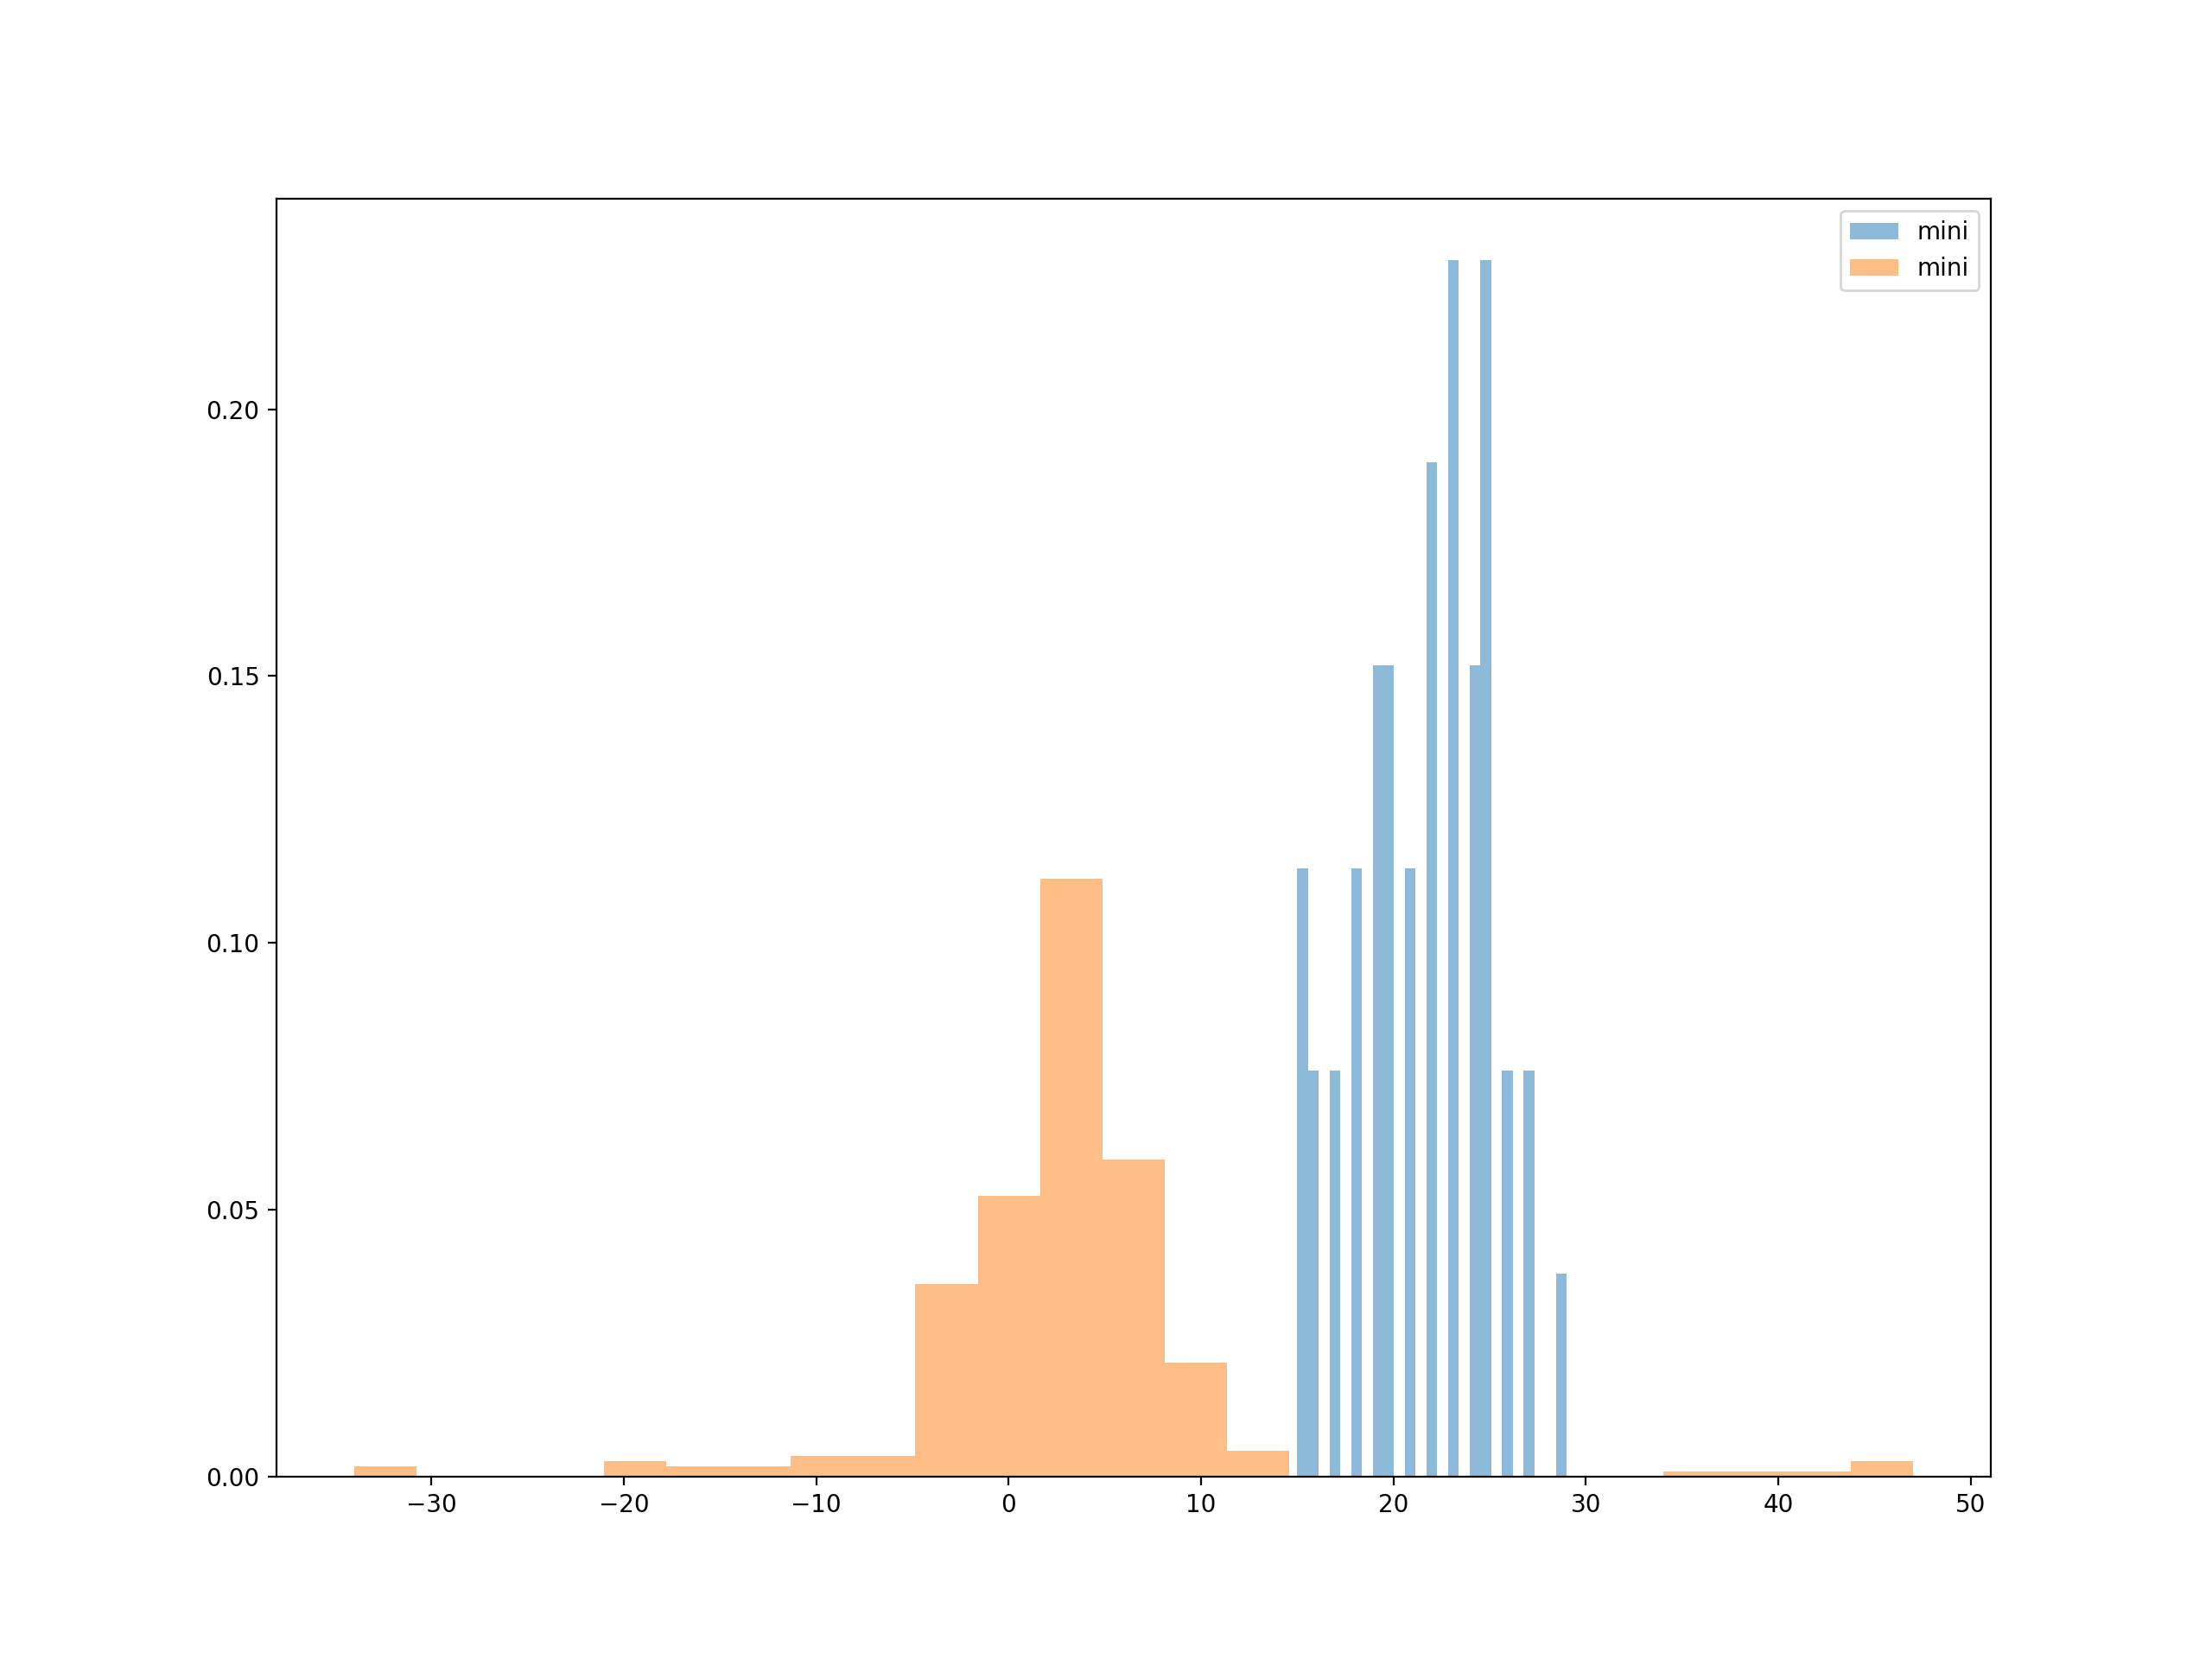

In [154]:
fig,ax = plt.subplots()

ax.hist(mini['trial length cor'], bins=25, density=True, alpha=0.5, label='mini')
ax.hist(not_mini['trial length cor'], bins=25, density=True, alpha=0.5, label='mini')

ax.legend()

## Event diff

In [348]:
event_dif_df = pd.DataFrame(columns=['session','tot. events', 'dif. events', "% dif",
                                    'start', 'cue', 'sound', 'openl.', 
                                     'gamble rw', 'gamble norw', 'safe rw','safe norw',
                                    'no resp.', 'iti', 'end',
                                    ])

for key,se in all_sessions_dict.items():
    dif_ev = np.sum(se.sync.combined_df['TTL Event']!=se.sync.combined_df['CSV Event'])
    all_ev = se.sync.combined_df.shape[0]
    per_ev = dif_ev/(all_ev/100)
    
    
    # get specific dif for each event type
    events_dif = list()
    for event_type in ['start', 'cue', 'sound', 'openloop',
                       'right_rw', 'right_norw', 'left_rw', 'left_norw',
                       'no response in time', 'iti', 'end'
                      ]:
        ev_df = se.sync.combined_df.loc[se.sync.combined_df['CSV Event']==event_type]
        per_ev_type = round_up(np.sum(ev_df['TTL Event']!=ev_df['CSV Event'])/(ev_df.shape[0]/100),2)
        events_dif.append(per_ev_type)
        
    if se.sync.gamble_side == 'right':
        events_dif_cor = events_dif
    else:
        events_dif_cor = events_dif[:4] + events_dif[6:8] + events_dif[4:6] + events_dif[8:]

    
    event_dif_df.loc[event_dif_df.shape[0]+1,:] = [key,all_ev,dif_ev,round_up(per_ev,2)]+events_dif_cor

event_dif_df

session tot. events dif. events  % dif  start    cue sound openl.  \
1   JG14_190621        2479         530  21.38  12.96  11.57  7.09  12.69   
2   JG14_190619        3687        1021  27.70   6.47   5.72  4.29   8.58   
3   JG14_190626        4395        1216  27.67  11.32   5.56  6.67   7.23   
4   JG15_190722        4070         661  16.25   5.23   5.02  3.65   5.70   
5   JG15_190725        4169         762  18.28  12.44  10.13  6.76  10.34   
6  JG18a_190814        3304         461  13.96   8.45   7.24  4.74   6.99   
7  JG18b_190828        3333         612  18.37  10.03  11.71  4.53  13.04   

  gamble rw gamble norw safe rw safe norw no resp.   iti   end  
1     11.91       15.26   20.64     21.43    15.39  4.87  3.38  
2      3.51        8.11    7.55      5.89     0.00  3.23  1.08  
3      6.35        6.25    7.57      5.00    16.28  5.85  2.79  
4      4.88        1.97    4.94      4.00    10.35  4.56  1.83  
5      7.82        9.34    7.33      3.85    10.53  8.25  3.60  
6      7.02       10.15   10.06      5.27    31.04  7.75  1.75  
7      0.00       16.67   10.05      0.00    15.16  6.94  3.74

In [339]:
print(event_dif_df.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
{} &       Session & tot. events & dif. events &  \% dif &  start &    cue & sound & openl. & gamble rw & gamble norw & safe rw & safe norw & no resp. &   iti &   end \\
\midrule
1 &   JG14\_190621 &        2479 &         530 &  21.38 &  12.96 &  11.57 &  7.09 &  12.69 &     11.91 &       15.26 &   20.64 &     21.43 &    15.39 &  4.87 &  3.38 \\
2 &   JG14\_190619 &        3687 &        1021 &  27.70 &   6.47 &   5.72 &  4.29 &   8.58 &      3.51 &        8.11 &    7.55 &      5.89 &     0.00 &  3.23 &  1.08 \\
3 &   JG14\_190626 &        4395 &        1216 &  27.67 &  11.32 &   5.56 &  6.67 &   7.23 &      6.35 &        6.25 &    7.57 &      5.00 &    16.28 &  5.85 &  2.79 \\
4 &   JG15\_190722 &        4070 &         661 &  16.25 &   5.23 &   5.02 &  3.65 &   5.70 &      4.88 &        1.97 &    4.94 &      4.00 &    10.35 &  4.56 &  1.83 \\
5 &   JG15\_190725 &        4169 &         762 &  18.28 &  12.44 &  10.13 &  6.76 &  10.34 &      7.82

In [358]:
fig, ax = fingerprint_color_map(event_dif_df)

savefig("event_type_dif", fig)

<IPython.core.display.Javascript object>

# Werkbank